# Data

## AWID3 Dataset

AWID3 dataset consists of 13 captures of traffic in a wireless network. Of these 7 that focus on attacks on IEEE 802.11 MAC layer. The attacks chosen are: 

* Deauth
* Disass
* (Re)Assoc
* RogueAP
* Krack
* Kr00k
* Evil Twin

## Data preprocessing

For training of the model 

Features selection was based on [Pick Quality Over Quantity: Expert Feature Selection and Data Preprocessing for 802.11 Intrusion Detection Systems](https://ieeexplore.ieee.org/document/9797689) by the authors of the AWID3 dataset:

### Features chosen by Chatzoglou et. al. and their preprocessing

| Feature                    | Preprocessing    |
|----------------------------|------------------|
| frame.len                  | Min-Max Scaling  |
| radiotap.len               | Min-Max Scaling  |
| radiotap.dbm_antsignal     | Min-Max Scaling  |
| wlan.duration              | Min-Max Scaling  |
| radiotap.present.tsft      | One Hot Encoding |
| radiotap.channel.freq      | One Hot Encoding |
| radiotap.channel.type.cck  | One Hot Encoding |
| radiotap.channel.type.ofdm | One Hot Encoding |
| wlan.fc.type               | One Hot Encoding |
| wlan.fc.subtype            | One Hot Encoding |
| wlan.fc.ds                 | One Hot Encoding |
| wlan.fc.frag               | One Hot Encoding |
| wlan.fc.retry              | One Hot Encoding |
| wlan.fc.pwrmgt             | One Hot Encoding |
| wlan.fc.moredata           | One Hot Encoding |
| wlan.fc.protected          | One Hot Encoding |

The chosen features were prepocessed with following differences:
* frame.delta_time was was was added, as it is crucial for analyzing temproal patterns.
* features expressed by 0/1 values, such as IEEE 802.11 Frame Control flags were left unchanged (e.g. frag, retry), not One Hot Encoded as in above mentioned article.
* the authors  One Hot Encoding of channel frequencies, however such approach is only feasable, when there rather few categories (3 frequencies were used in the above mentioned files), so a more genral method of preprocessing frequncy is proposed:
    * create two binary features `2ghz_spectrum` and `5ghz_spectrum` to indicate in which band a frame was sent
    * apply Min-Max Scaling to frequency, using the highest and the lowest channel frequency in given band as Min and Max values, as seen below

In [2]:
def preporcess_frequency(radiotap_channel_freq):
    lower_2ghz, higher_2ghz = 2412, 2472
    lower_5ghz, higher_5gzh = 5160, 5885
    
    if (lower_2ghz <= radiotap_channel_freq <= higher_2ghz):
        _2ghz_spectrum = 1
        _5gzh_spectrum = 0
        freq = (radiotap_channel_freq - lower_2ghz) / (higher_2ghz - lower_2ghz)
    elif (lower_5ghz <= radiotap_channel_freq <= higher_5ghz):
        _2ghz_spectrum = 0
        _5gzh_spectrum = 1
        freq = (radiotap_channel_freq - lower_5ghz) / (higher_5ghz - lower_5ghz)
    else:
        _2ghz_spectrum = 0
        _5gzh_spectrum = 0
        freq = -1
        
    return _2ghz_spectrum, _5gzh_spectrum, freq
     

### Features and used preprocessing

| Feature                   | Type        | Preprocessing       | Values                    | Description                                                                                                       |
|---------------------------|-------------|---------------------|---------------------------|-------------------------------------------------------------------------------------------------------------------|
| frame.len                 | numeric     | Min-Max Scaling     | from 70 to 3220           | Length of frame, in bytes                                                                                         |
| frame.time_delta          | numeric     | Min-Max Scaling     | from 0 to 0.001817        | Time interval since previous frame, in seconds                                                                    |
| radiotap.len              | numeric     | Min-Max Scaling     | from 48 to 64             | Length of Radiotap header, in bytes                                                                               |
| radiotap.dbm_antsignal    | numeric     | Min-Max Scaling     | form -255 to -78          | Strength of recieved signal, in dBm. In AWID3 CSV files the value was summarized for antennas, hence very low values |
| wlan.duration             | numeric     | Min-Max Scaling     | from 0 to 726             | Duration/Id field in IEEE 802.11 header                                                                           |
| wlan.fc.type              | categorical | One Hot Encoding    | 0, 1, 2                   | IEEE 802.11 frame type: Management, Control or Data                                                               |
| wlan.fc.subtype           | categorical | One Hot Encoding    | 0, 1, ... 14, 15          | IEEE 802.11 frame subtype                                                                                         |
| wlan.fc.ds                | categorical | One Hot Encoding    | 0, 1, 2, 3                | Indicates whete a frame was sent to (tods) or from (fromds) a Distribution System (ds), neither or both           |
| radiotap.present.tsft     | binary      | convert to 0,1      | '0-0-0', '1-0-0'          | Presence of TSFT (Time Synchroniztion Function) in Radiotap header                                                |
| radiotap.channel.type.cck | binary      | None                | 0, 1                      | Whether frame was sent using CCK (Complemantary Code Keying), used in IEEE 802.11b                                |
| radiotap.channel.type.ofdm | binary     | None                | 0, 1                      | Whether frame was sent using OFDM (Orthognal Frequency Division Multiplexing) modulation                          |
| wlan.fc.frag              | binary      | None                | 0, 1                      | Frame Control flag, indicates if the frame was fragmented                                                         |
| wlan.fc.retry             | binary      | None                | 0, 1                      | Frame Control flag, indicates if the frame is retransmission of a previous frame                                  |
| wlan.fc.pwrmgt            | binary      | None                | 0, 1                      | Frame Control flag, used when station enters power management state                                               |
| wlan.fc.moredata          | binary      | None                | 0, 1                      | Frame Control flag, indicates that AP has buffered for the station                                                |
| wlan.fc.protected         | binary      | None                | 0, 1                      | Frame Control flag, indicates that frame has been encrypted                                                       |
| 2ghz_spectrum             | binary      | None                | 0, 1                      | The channel the frame was sent in is in 2.4GHz band                                                               |
| 5ghz_spectrum             | binary      | None                | 0, 1                      | The channel the frame was sent in is in 5GHz band                                                                 |
| freq                      | numeric     | As described above  | from 0 to 1               | Frequency scaled for the band station works in                                                                    |
| Label                     | Categorical | Convert to 0, 1, 2  | 'Normal' and attacks      | Label of given to the frame                                                                                      | 

Minimal and maximal values for ranges were estimated accros all AWID3 files, IQR was used to exckude otliers, that were then clipped into range 0, 1.

The traffic was divided into 3 classes:

Classes:

| Class | name           | Attacks                                                               |
|-------|----------------|-----------------------------------------------------------------------|
| 0     | normal         |                                                                       |
| 1     | flooding       | Deauth, Disass, (Re)Assoc, Kr00k                                      |
| 2     | impersonation  | RogueAP, Krack, Evil Twin                                             |

Both binary, and multiclass classificators were trained and evaluated on the dataset.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np

tfrecords_dir='dataset/AWID3_tfrecords'
tfrecords_balanced_dir='dataset/AWID3_tfrecords_balanced'

sequence_length = 128
sequence_shift = 120
n_features = 39

from collections import defaultdict

E0000 00:00:1733754456.282228    7174 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733754456.287966    7174 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import data_utils

files = os.listdir(tfrecords_dir)

train_ratio = 0.8
train_files, test_files = data_utils.train_test_split(files, train_ratio=train_ratio)
train_files, val_files = data_utils.train_test_split(train_files, train_ratio=train_ratio)

print("Training set:")
for t in train_files:
    print(t.split('.')[0], end=', ')

print("\nValidation set:")
for t in val_files:
    print(t.split('.')[0], end=', ')

print("\nTest set:")
for t in test_files:
    print(t.split('.')[0], end=', ')
    
train_seq_files = [os.path.join(tfrecords_dir, f) for f in train_files]
val_seq_files = [os.path.join(tfrecords_dir, f) for f in val_files]
test_seq_files = [os.path.join(tfrecords_dir, f) for f in test_files]
train_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in train_files]
val_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in val_files]
test_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in test_files]



Training set:
Disas_35, RogueAP_27, (Re)Assoc_32, Deauth_31, Kr00k_55, Evil_Twin_61, (Re)Assoc_35, Krack_25, Kr00k_52, (Re)Assoc_28, Evil_Twin_75, Evil_Twin_37, (Re)Assoc_27, Evil_Twin_54, Evil_Twin_63, Kr00k_56, RogueAP_29, Evil_Twin_32, Disas_37, Kr00k_39, Disas_36, Evil_Twin_33, Kr00k_36, RogueAP_33, RogueAP_39, (Re)Assoc_24, (Re)Assoc_34, Evil_Twin_46, RogueAP_37, Disas_39, (Re)Assoc_25, Deauth_29, Kr00k_43, Kr00k_48, Deauth_32, Evil_Twin_65, Deauth_27, Disas_28, Kr00k_46, Kr00k_51, Deauth_21, Evil_Twin_36, RogueAP_31, Evil_Twin_40, Kr00k_34, Evil_Twin_29, Evil_Twin_71, Evil_Twin_66, Disas_40, Evil_Twin_56, (Re)Assoc_31, Disas_31, Disas_29, RogueAP_28, Evil_Twin_68, Evil_Twin_49, Kr00k_45, Evil_Twin_42, Krack_26, Evil_Twin_30, Deauth_25, Evil_Twin_72, Evil_Twin_39, (Re)Assoc_26, Evil_Twin_60, RogueAP_24, Deauth_24, Kr00k_35, Evil_Twin_58, Kr00k_57, RogueAP_26, Evil_Twin_44, Kr00k_40, RogueAP_25, Evil_Twin_52, Evil_Twin_59, Deauth_23, Evil_Twin_74, RogueAP_35, Evil_Twin_70, Kr00k_53

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import seaborn as sns

# functions for plotting and confusion matrix

def score_and_confusion_matrix(y_pred, y_true, title : str, binary = True, average='binary'):
    class_names = [
        'Normal', 'Attack'
    ] if binary else [
        'Normal', 'Flooding', 'Impersonation'
    ]
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f'Accuracy: {100*accuracy:2.3f}%')
    print(f'Precision: {100*precision:2.3f}%')
    print(f'Recall: {100*recall:2.3f}%')
    print(f'F1 : {f1:.4f}')
    print(f'Kappa: {kappa:.4f}')
    
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: ' + title)
    plt.show()
    
    return accuracy, precision, recall, f1, kappa
    
def plot_model_history(history, title):
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title)
    
    if 'accuracy' in history:
        axes[0, 0].plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            axes[0, 0].plot(history['val_accuracy'], label='Val Accuracy')
        axes[0, 0].set_title('Accuracy')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
    
    # Plot Precision
    if 'precision' in history:
        axes[0, 1].plot(history['precision'], label='Train Precision')
        if 'val_precision' in history:
            axes[0, 1].plot(history['val_precision'], label='Val Precision')
        axes[0, 1].set_title('Precision')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].legend()
    
    if 'recall' in history:
        axes[1, 0].plot(history['recall'], label='Train Recall')
        if 'val_recall' in history:
            axes[1, 0].plot(history['val_recall'], label='Val Recall')
        axes[1, 0].set_title('Recall')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Recall')
        axes[1, 0].legend()
    
    if 'loss' in history:
        axes[1, 1].plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            axes[1, 1].plot(history['val_loss'], label='Val Loss')
        axes[1, 1].set_title('Loss')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()    
    plt.tight_layout()
    plt.show()
        

In [6]:
import binary_cnn_lstm
import data_utils

bin_cnn_lstm_model = binary_cnn_lstm.binary_CNN_LSTM_model()

if not bin_cnn_lstm_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        bin_cnn_lstm_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[binary_cnn_lstm.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Binary CNN-LSTM")
    print(history)
    #loading best checkpoint
    bin_cnn_lstm_model = binary_cnn_lstm.binary_CNN_LSTM_model()
    
bin_cnn_lstm_model.name = 'bin_CNN_LSTM'    
bin_cnn_lstm_model.summary()


I0000 00:00:1733754481.877014    7174 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4962 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Model loaded from saved_models/binary_cnn_lstm.keras


Model: "bin_CNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 32)       │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 24)       │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 16)       │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_dense (TimeDistributed)      │ (None, None, 8)        │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_output (TimeDistributed)     │ (None, None, 1)        │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,525 (56.74 KB)

 Trainable params: 4,841 (18.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,684 (37.83 KB)

/home/filip/.local/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
I0000 00:00:1733754619.095120  176686 cuda_dnn.cc:529] Loaded cuDNN version 90300


222/222 ━━━━━━━━━━━━━━━━━━━━ 59s 261ms/step
Accuracy: 98.792%
Precision: 91.295%
Recall: 98.053%
F1 : 0.9455
Kappa: 0.9388


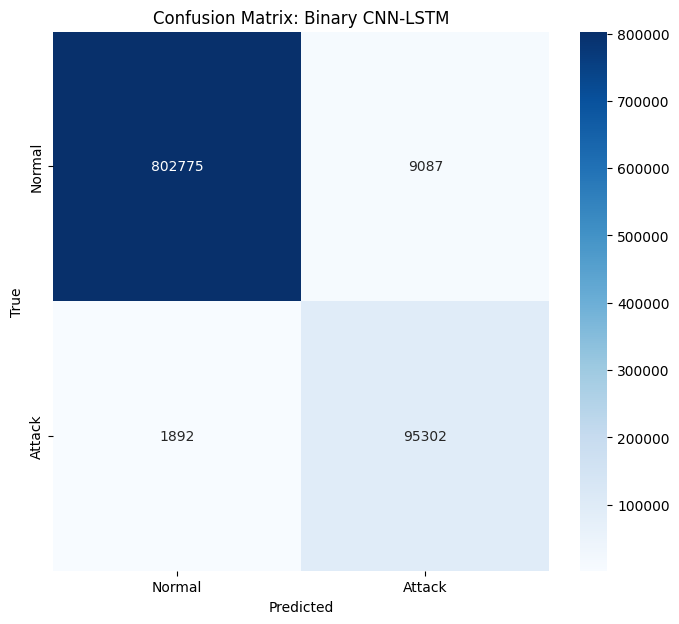

In [7]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_lstm_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn_lstm_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary CNN-LSTM")


In [8]:
import binary_td_cnn
import data_utils

bin_td_cnn_model = binary_td_cnn.binary_time_domain_CNN_model()

if not bin_td_cnn_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        bin_td_cnn_model,
        dataset_lambda,
        epochs_per_step=3,
        training_callbacks=[binary_td_cnn.checkpoint_callback],
        n_initial_files = 10,
        increment = 0.5
        
    )
    history = {}
    for h in histories:
        for metric, values in h.items():
            if not history[metric]:
                history[metric] = values
            else:
                history[metric].extend[values] 
    
    plot_model_history(history, "Binary Time Domain CNN")
    #loading best checkpoint
    bin_td_cnn_model = binary_td_cnn.binary_time_domain_CNN_model()
    
bin_td_cnn_model.name = 'bin_TD_CNN'    
bin_td_cnn_model.summary()

Model loaded from saved_models/binary_td_cnn.keras


Model: "bin_TD_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (32, 128, 32)          │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 128, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (32, 128, 16)          │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 128, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 128, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_output (TimeDistributed)     │ (32, 128, 1)           │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,053 (117.40 KB)

 Trainable params: 9,985 (39.00 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 19,972 (78.02 KB)

/home/filip/.local/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 29s 128ms/step
Accuracy: 95.407%
Precision: 89.891%
Recall: 64.270%
F1 : 0.7495
Kappa: 0.7250


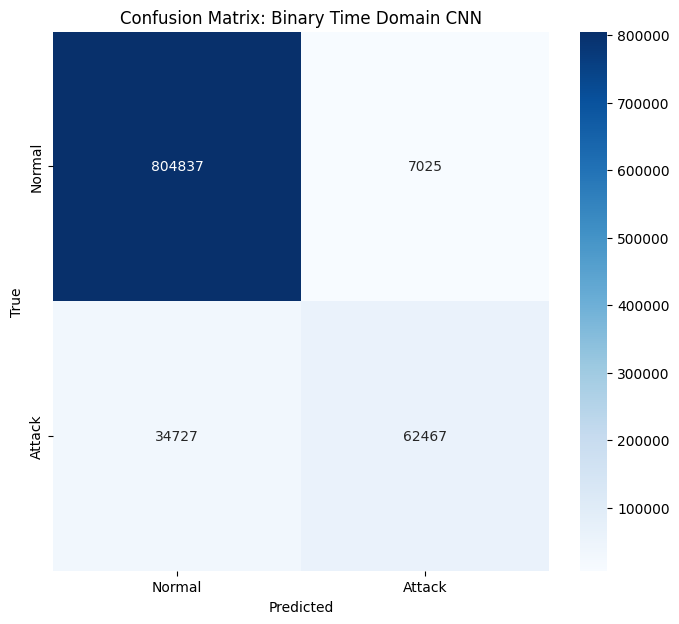

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_td_cnn_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_td_cnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary Time Domain CNN")


In [10]:
import binary_cnn_gru
import data_utils

bin_cnn_gru_model = binary_cnn_gru.binary_CNN_GRU_model() 

if not bin_cnn_gru_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        bin_td_cnn_model,
        dataset_lambda,
        epochs_per_step=3,
        training_callbacks=[bin_cnn_gru_model.checkpoint_callback],
        n_initial_files = 10,
        increment = 0.5
        
    )
    history = {}
    for h in histories:
        for metric, values in h.items():
            if not history[metric]:
                history[metric] = values
            else:
                history[metric].extend[values] 
    
    plot_model_history(history, "Binary CNN")
    #loading best checkpoint
    bin_cnn_gru_model = binary_cnn_gru.binary_CNN_GRU_model()
    
    
bin_cnn_gru_model.summary()
bin_cnn_gru_model.name = 'binary_CNN_GRU'

Model loaded from saved_models/binary_cnn_gru.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 48)       │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 32)       │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 24)       │         4,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 12)       │           300 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 1)        │            13 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,933 (93.49 KB)

 Trainable params: 7,977 (31.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,956 (62.33 KB)

/home/filip/.local/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step
Accuracy: 98.952%
Precision: 91.447%
Recall: 99.505%
F1 : 0.9531
Kappa: 0.9472


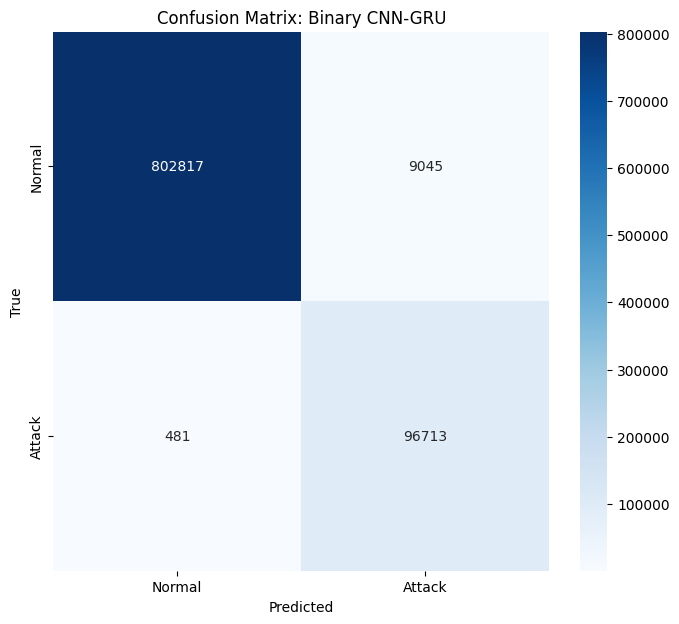

In [11]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_gru_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn_gru_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary CNN-GRU")


Model loaded from saved_models/binary_cnn1d.keras


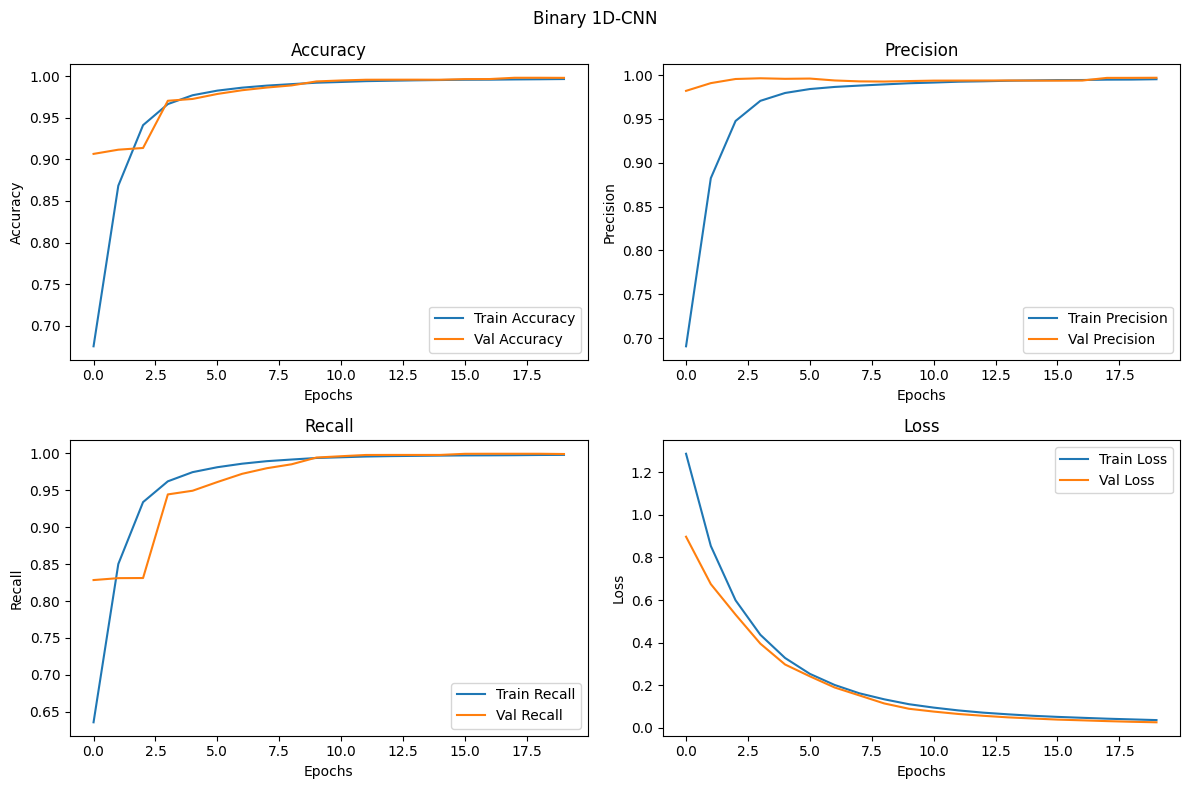

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 39)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 24)          │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 24)          │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 24)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 16)          │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 12)          │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 12)          │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,513 (21.54 KB)

 Trainable params: 1,797 (7.02 KB)

 Non-trainable params: 120 (480.00 B)

 Optimizer params: 3,596 (14.05 KB)

In [12]:
import binary_cnn1d
import data_utils

bin_cnn1d_model = binary_cnn1d.binary_CNN1D_model()

if not bin_cnn1d_model.built:
    bin_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    bin_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = bin_cnn1d_model.fit(
            bin_bal_train_ds,
            validation_data = bin_bal_val_ds,
            epochs=30,
            callbacks = [binary_cnn1d.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Binary 1D-CNN')
else:
    history = {'accuracy': [0.6756052374839783, 0.8683481216430664, 0.9410319924354553, 0.966303288936615, 0.9769217371940613, 0.982466459274292, 0.9860230088233948, 0.98848557472229, 0.990267276763916, 0.9919653534889221, 0.9928493499755859, 0.9938392043113708, 0.994346022605896, 0.9948341250419617, 0.9951976537704468, 0.9955116510391235, 0.9956071972846985, 0.9959024786949158, 0.9960986971855164, 0.9963700771331787], 'loss': [1.2863292694091797, 0.8537745475769043, 0.5986388921737671, 0.4369931221008301, 0.32793357968330383, 0.2535191774368286, 0.20141451060771942, 0.16224375367164612, 0.1341075599193573, 0.11108948290348053, 0.09511548280715942, 0.0818987786769867, 0.07140924781560898, 0.06358933448791504, 0.05671337619423866, 0.051536787301301956, 0.04726158082485199, 0.04309292882680893, 0.03975311666727066, 0.036497268825769424], 'precision': [0.6907044053077698, 0.8823795914649963, 0.9475935697555542, 0.9705383777618408, 0.9795224070549011, 0.9840027689933777, 0.9864014983177185, 0.9879310131072998, 0.9892802834510803, 0.9905923008918762, 0.9914035797119141, 0.9923737645149231, 0.9928304553031921, 0.993458092212677, 0.9938491582870483, 0.9942060708999634, 0.9942913055419922, 0.9947120547294617, 0.9948084354400635, 0.9951919913291931], 'recall': [0.636017382144928, 0.8500005006790161, 0.9337021708488464, 0.9618029594421387, 0.9742099046707153, 0.9808793067932129, 0.985633909702301, 0.9890539050102234, 0.9912759065628052, 0.9933647513389587, 0.9943204522132874, 0.995327353477478, 0.9958837032318115, 0.9962283968925476, 0.9965628981590271, 0.996832549571991, 0.9969383478164673, 0.997105598449707, 0.997402548789978, 0.9975595474243164], 'val_accuracy': [0.9065394401550293, 0.9115726947784424, 0.9136363863945007, 0.9702883958816528, 0.9724753499031067, 0.9784680604934692, 0.9829331040382385, 0.986181378364563, 0.9887328743934631, 0.9935141801834106, 0.9946558475494385, 0.9955295920372009, 0.9955939054489136, 0.9956153631210327, 0.9955510497093201, 0.9962692856788635, 0.9963657855987549, 0.9978934526443481, 0.9979095458984375, 0.9977969527244568], 'val_loss': [0.8969818949699402, 0.6747214794158936, 0.531442403793335, 0.39536020159721375, 0.2973610758781433, 0.24192996323108673, 0.18957529962062836, 0.15230363607406616, 0.11475236713886261, 0.08968057483434677, 0.07647109776735306, 0.06515474617481232, 0.056668128818273544, 0.04932112246751785, 0.04404512420296669, 0.03883887082338333, 0.03533818945288658, 0.03167106583714485, 0.028574012219905853, 0.02615336887538433], 'val_precision': [0.9819408655166626, 0.9907453656196594, 0.9954543113708496, 0.9962780475616455, 0.9956588745117188, 0.9959551692008972, 0.9937849640846252, 0.992742121219635, 0.9925558567047119, 0.9930912852287292, 0.9935922622680664, 0.9936561584472656, 0.9937202334403992, 0.9937837719917297, 0.9936459064483643, 0.9935812950134277, 0.9936982989311218, 0.9967272281646729, 0.9967592358589172, 0.9968647956848145], 'val_recall': [0.8283126354217529, 0.8309069275856018, 0.8310677409172058, 0.9441037774085999, 0.9490887522697449, 0.9608383178710938, 0.9719446897506714, 0.9795240163803101, 0.9848520755767822, 0.9939429759979248, 0.9957332611083984, 0.9974271059036255, 0.9974914193153381, 0.997469961643219, 0.9974806904792786, 0.9989922642707825, 0.9990673065185547, 0.9990673065185547, 0.9990673065185547, 0.9987350106239319]}
    plot_model_history(history, 'Binary 1D-CNN')
    
bin_cnn1d_model.summary()


/home/filip/.local/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


28408/28408 ━━━━━━━━━━━━━━━━━━━━ 460s 16ms/step
Accuracy: 98.795%
Precision: 89.953%
Recall: 99.884%
F1 : 0.9466
Kappa: 0.9398


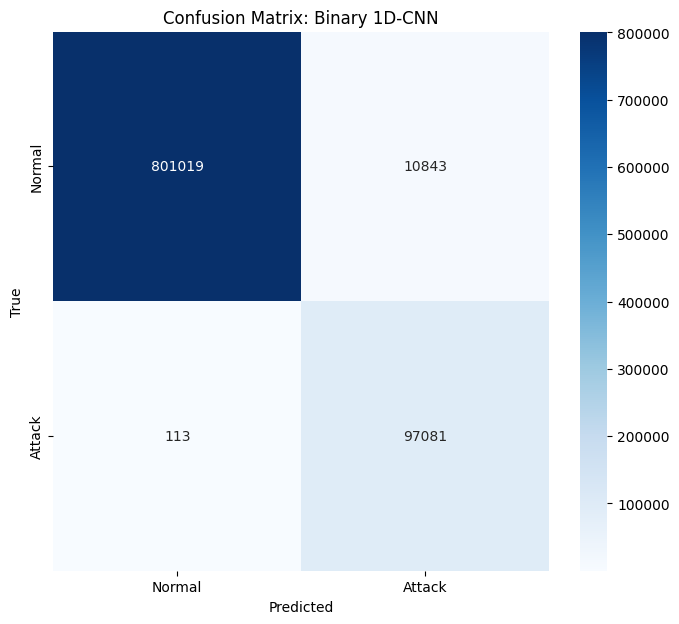

In [13]:
binary_bal_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in binary_bal_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn1d_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn1d_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary 1D-CNN')


Model loaded from saved_models/binary_dnn.keras


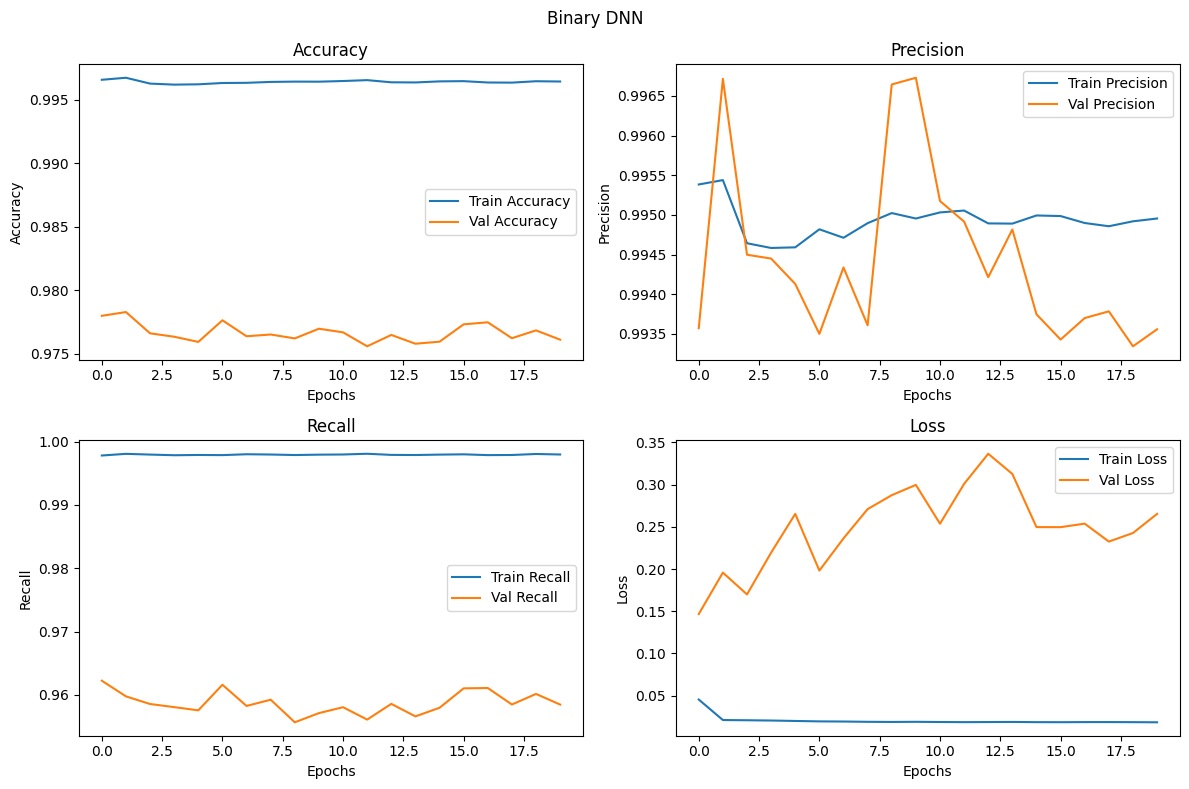

In [14]:
import binary_dnn
import data_utils

bin_dnn_model = binary_dnn.binary_DNN_model()

if not bin_dnn_model.built:
    bin_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    bin_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = bin_dnn_model.fit(
            bin_bal_train_ds,
            validation_data = bin_bal_val_ds,
            epochs=30,
            callbacks = [binary_cnn1d.checkpoint_callback],
        )
    bin_dnn_model.summary()
    plot_model_history(history.history, 'Binary DNN')
else:
    history = {'accuracy': [0.9965814352035522, 0.9967400431632996, 0.9962809681892395, 0.9961997270584106, 0.9962242245674133, 0.9963274002075195, 0.9963415861129761, 0.9964125156402588, 0.9964370131492615, 0.996431827545166, 0.9964834451675415, 0.9965530633926392, 0.9963828325271606, 0.9963712096214294, 0.9964550733566284, 0.9964731335639954, 0.996367335319519, 0.9963570237159729, 0.9964666366577148, 0.9964447617530823], 'loss': [0.04539966955780983, 0.0211204681545496, 0.020860230550169945, 0.020531700924038887, 0.020026005804538727, 0.019525228068232536, 0.019351119175553322, 0.019010372459888458, 0.018851708620786667, 0.019014867022633553, 0.018782394006848335, 0.018619699403643608, 0.01873910427093506, 0.01886620558798313, 0.01861356571316719, 0.018561752513051033, 0.018678661435842514, 0.018701180815696716, 0.018609831109642982, 0.018442774191498756], 'precision': [0.9953842759132385, 0.9954392910003662, 0.9946429133415222, 0.9945835471153259, 0.994591474533081, 0.994818925857544, 0.994712233543396, 0.9948961734771729, 0.9950236678123474, 0.9949548840522766, 0.9950317740440369, 0.9950553774833679, 0.9948933124542236, 0.9948906302452087, 0.9949933290481567, 0.9949858784675598, 0.99489825963974, 0.9948574304580688, 0.9949195981025696, 0.9949550032615662], 'recall': [0.997789740562439, 0.9980527758598328, 0.9979367256164551, 0.9978335499763489, 0.9978748559951782, 0.9978516101837158, 0.9979883432388306, 0.9979444742202759, 0.9978645443916321, 0.9979238510131836, 0.9979496598243713, 0.998065710067749, 0.9978877305984497, 0.9978671073913574, 0.9979315996170044, 0.9979754090309143, 0.9978516101837158, 0.9978722333908081, 0.9980295896530151, 0.9979496598243713], 'val_accuracy': [0.9780026078224182, 0.978299081325531, 0.9766246676445007, 0.9763556718826294, 0.9759494662284851, 0.9776512980461121, 0.9763941168785095, 0.9765313863754272, 0.9762239456176758, 0.9769870042800903, 0.976701557636261, 0.9756035804748535, 0.9764984250068665, 0.975806713104248, 0.9759659171104431, 0.9773328900337219, 0.977492094039917, 0.9762403964996338, 0.9768552780151367, 0.9761251211166382], 'val_loss': [0.1466568261384964, 0.19578522443771362, 0.16991949081420898, 0.21944405138492584, 0.2653358578681946, 0.19818998873233795, 0.23630042374134064, 0.2709701955318451, 0.2874850630760193, 0.2996620535850525, 0.25369521975517273, 0.30087709426879883, 0.33655574917793274, 0.3126213550567627, 0.2496926337480545, 0.24959908425807953, 0.253773957490921, 0.23254331946372986, 0.24266037344932556, 0.26534149050712585], 'val_precision': [0.9935718774795532, 0.9967161417007446, 0.994498074054718, 0.9944499135017395, 0.9941295981407166, 0.9934999942779541, 0.9943376779556274, 0.9936084151268005, 0.9966450929641724, 0.9967299103736877, 0.9951757192611694, 0.9949157238006592, 0.9942150712013245, 0.9948161840438843, 0.9937470555305481, 0.9934285283088684, 0.9936995506286621, 0.9937843680381775, 0.9933435320854187, 0.9935581088066101], 'val_recall': [0.9622305631637573, 0.9597601890563965, 0.9585524797439575, 0.9580584168434143, 0.9575533270835876, 0.9615938067436218, 0.958245038986206, 0.9592331647872925, 0.955664873123169, 0.9571141600608826, 0.9580473899841309, 0.9560930728912354, 0.9585744142532349, 0.9565981030464172, 0.9579595923423767, 0.9610228538513184, 0.9610777497291565, 0.9584755897521973, 0.9601444602012634, 0.9584646224975586]}	
    plot_model_history(history, 'Binary DNN')

/home/filip/.local/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


28408/28408 ━━━━━━━━━━━━━━━━━━━━ 215s 8ms/step
Accuracy: 98.393%
Precision: 89.714%
Recall: 95.974%
F1 : 0.9274
Kappa: 0.9184


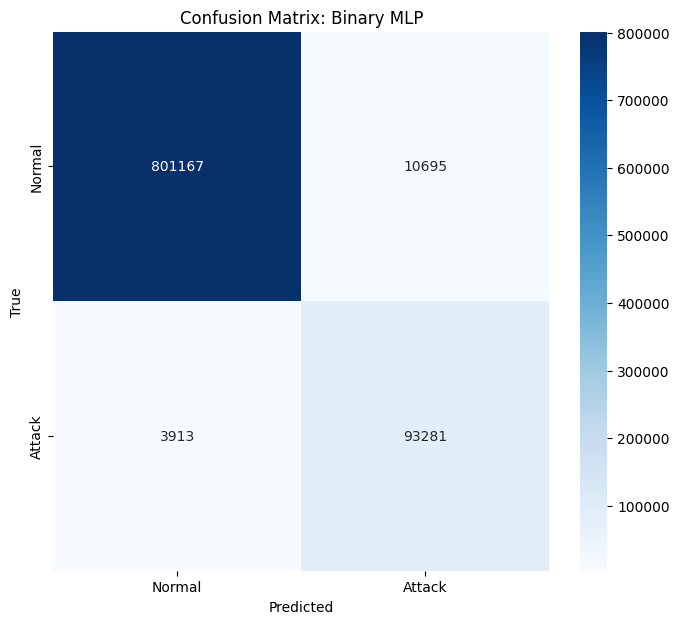

In [15]:
binary_bal_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in binary_bal_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_dnn_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_dnn_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary MLP')

### Results:

* Binary CNN-LSTM
    * Accuracy: 98.792%
    * Precision: 91.295%
    * Recall: 98.053%
    * F1 : 0.9455
    * Kappa: 0.9388
* Binary CNN-GRU
    * Accuracy: 98.952%
    * Precision: 91.447%
    * Recall: 99.505%
    * F1 : 0.9531
    * Kappa: 0.9472
* Binary Time Domain CNN
    * Accuracy: 95.407%
    * Precision: 89.891%
    * Recall: 64.270%
    * F1 : 0.7495
    * Kappa: 0.7250
* Binary 1D-CNN
    * Accuracy: 98.795%
    * Precision: 89.953%
    * Recall: 99.884%
    * F1 : 0.9466
    * Kappa: 0.9398
* Binary DNN
    * Accuracy: 98.393%
    * Precision: 89.714%
    * Recall: 95.974%
    * F1 : 0.9274
    * Kappa: 0.9184


In [18]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

bin_arithmetic_mean_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_arithmetic_mean_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_arithmetic_mean_aggregate1.summary()

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │      4,841 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      7,977 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None, 1)   │      1,917 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, None, 1)   │          0 │ bin_CNN_LSTM[0][… │
│                     │                   │            │ binary_CNN_GRU[0… │
│                     │                   │            │ time_distributed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,735 (57.56 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,735 (57.56 KB)

/home/filip/.local/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 549s 2s/step
Accuracy: 98.792%
Precision: 90.027%
Recall: 99.755%
F1 : 0.9464
Kappa: 0.9396


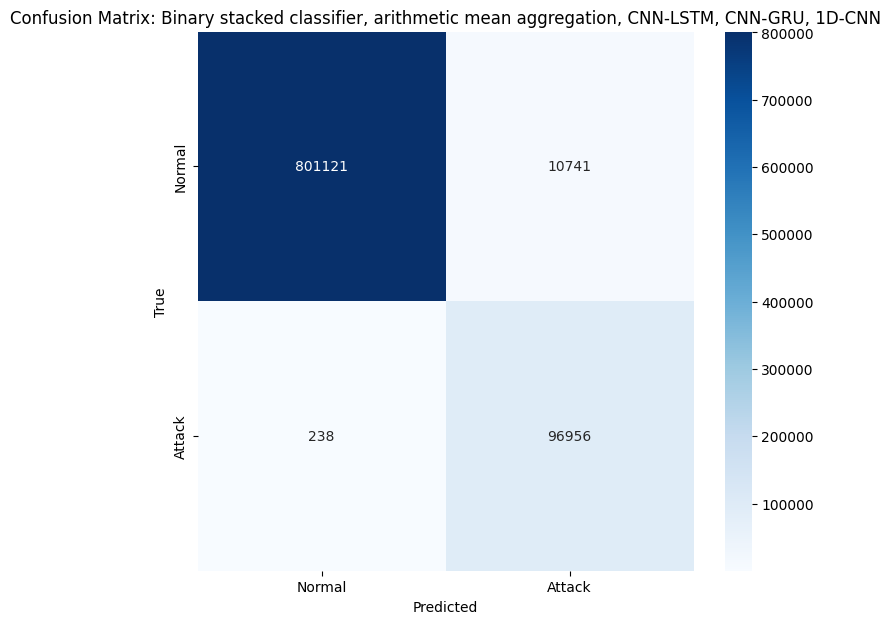

In [19]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_arithmetic_mean_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_arithmentic_mean_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, arithmetic mean aggregation, CNN-LSTM, CNN-GRU, 1D-CNN')

In [21]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
]

bin_f1_weights = [
    bin_cnn_lstm_metrics[3],
    bin_cnn_gru_metrics[3],
    bin_cnn1d_metrics[3],
]

bin_f1_weights = [math.log(w / (1 - w)) for w in bin_f1_weights]

sum_bin_f1_weights = sum(bin_f1_weights)

bin_f1_weights = tf.constant([w / sum_bin_f1_weights for w in bin_f1_weights], dtype=tf.float32)

print('F1 calculated_weights')
print(bin_f1_weights.numpy())

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_f1_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_f1_weighted_aggregate1 = tf.keras.Model(input, y)


bin_f1_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_f1_weighted_aggregate1.summary()

F1 calculated_weights
[0.3265732 0.3444975 0.3289293]


Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │      4,841 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      7,977 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None, 1)   │      1,917 │ input_layer_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[1][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[1… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None, 3)   │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, None, 3)   │          0 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,735 (57.56 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,735 (57.56 KB)

/home/filip/.local/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step
Accuracy: 98.793%
Precision: 90.032%
Recall: 99.754%
F1 : 0.9464
Kappa: 0.9397


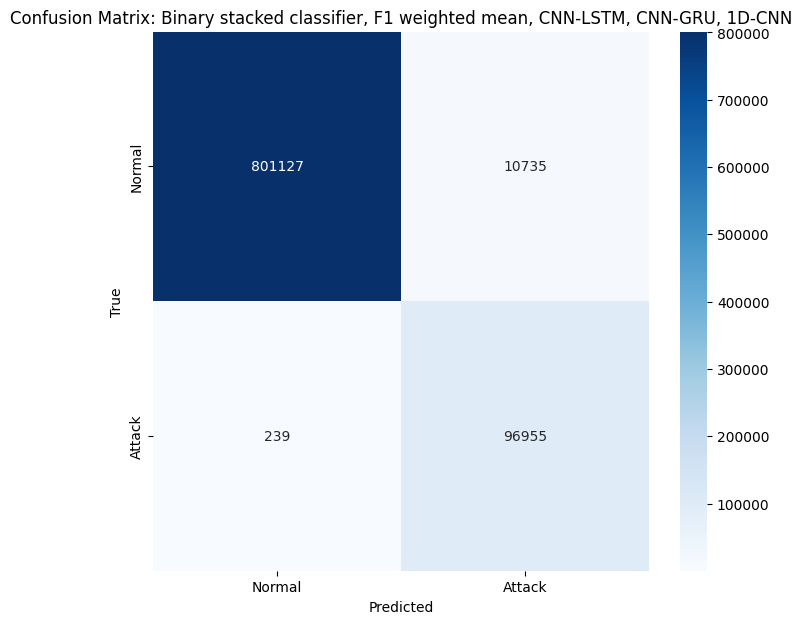

In [22]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_f1_weighted_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_f1_weighted_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, F1 weighted mean, CNN-LSTM, CNN-GRU, 1D-CNN')

In [23]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
]

bin_kappa_weights = [
    bin_cnn_lstm_metrics[4],
    bin_cnn_gru_metrics[4],
    bin_cnn1d_metrics[4],
]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print('Kappa score calculated weights')
print(bin_kappa_weights.numpy())

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_kappa_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_kappa_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_aggregate1.summary()

Kappa score calculated weights
[0.32794467 0.34239936 0.32965598]


Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │      4,841 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      7,977 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, None, 1)   │      1,917 │ input_layer_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[2][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[2… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, None, 3)   │          0 │ lambda_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,735 (57.56 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,735 (57.56 KB)

/home/filip/.local/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step
Accuracy: 98.793%
Precision: 90.032%
Recall: 99.754%
F1 : 0.9464
Kappa: 0.9397


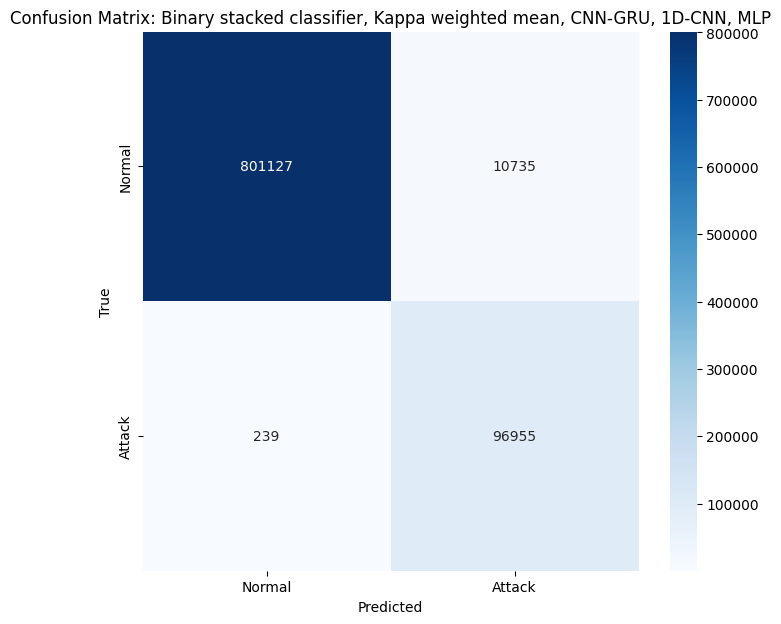

In [24]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
kappa_weighted_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Kappa weighted mean, CNN-GRU, 1D-CNN, MLP')

In [25]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape
input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
]


# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(combined_output)


bin_stacked_log_regressor1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_stacked_log_regressor1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_log_regressor1.summary()

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │      4,841 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      7,977 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, None, 1)   │      1,917 │ input_layer_3[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[3][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[3… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, None, 1)   │          4 │ concatenate_3[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,739 (57.57 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 14,735 (57.56 KB)

Epoch 1/3
  17685/Unknown 186s 10ms/step - accuracy: 0.9974 - loss: 0.2224 - precision: 0.9963 - recall: 0.9985

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17685/17685 ━━━━━━━━━━━━━━━━━━━━ 232s 13ms/step - accuracy: 0.9974 - loss: 0.2224 - precision: 0.9963 - recall: 0.9985 - val_accuracy: 0.9979 - val_loss: 0.2190 - val_precision: 0.9970 - val_recall: 0.9988
Epoch 2/3
17685/17685 ━━━━━━━━━━━━━━━━━━━━ 241s 14ms/step - accuracy: 0.9974 - loss: 0.2225 - precision: 0.9963 - recall: 0.9985 - val_accuracy: 0.9979 - val_loss: 0.2190 - val_precision: 0.9970 - val_recall: 0.9988
Epoch 3/3
17685/17685 ━━━━━━━━━━━━━━━━━━━━ 238s 13ms/step - accuracy: 0.9976 - loss: 0.2224 - precision: 0.9965 - recall: 0.9986 - val_accuracy: 0.9979 - val_loss: 0.2189 - val_precision: 0.9970 - val_recall: 0.9988


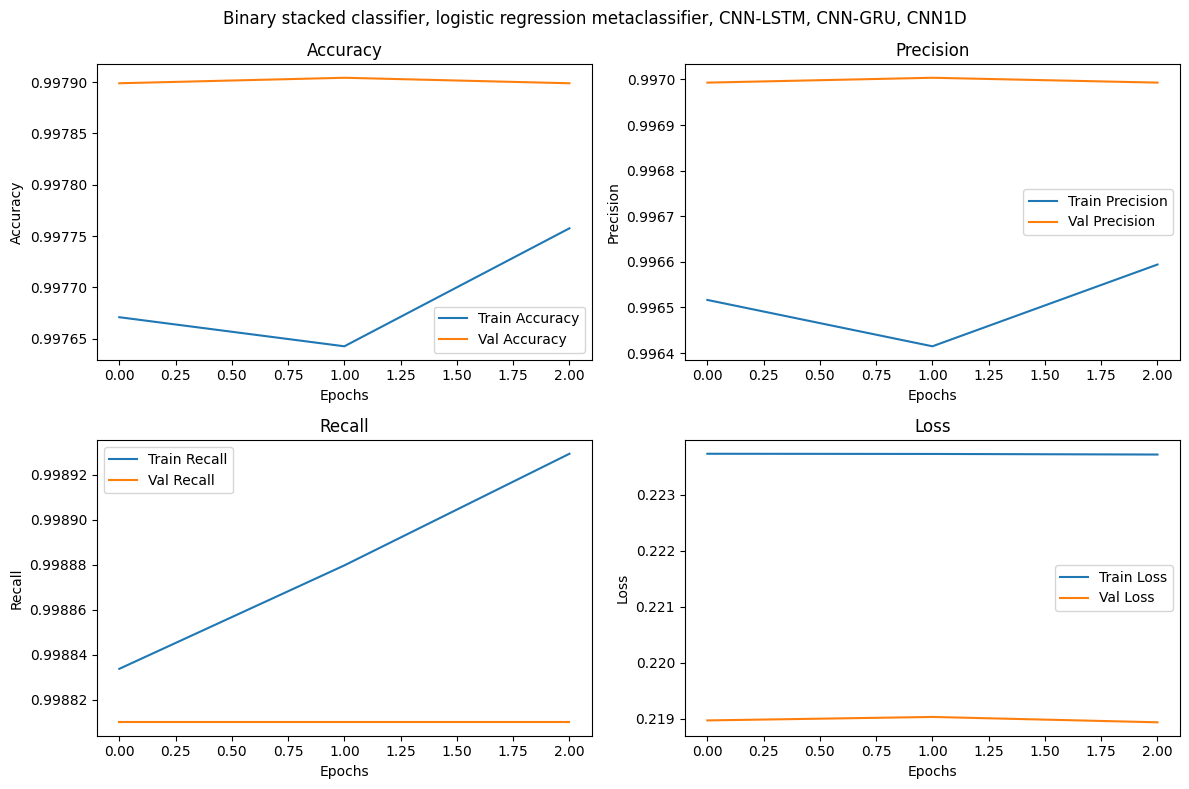

In [27]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
history = bin_stacked_log_regressor1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)
plot_model_history(history.history, 'Binary stacked classifier, logistic regression metaclassifier, CNN-LSTM, CNN-GRU, CNN1D')

222/222 ━━━━━━━━━━━━━━━━━━━━ 55s 153ms/step
Accuracy: 98.788%
Precision: 89.977%
Recall: 99.784%
F1 : 0.9463
Kappa: 0.9395


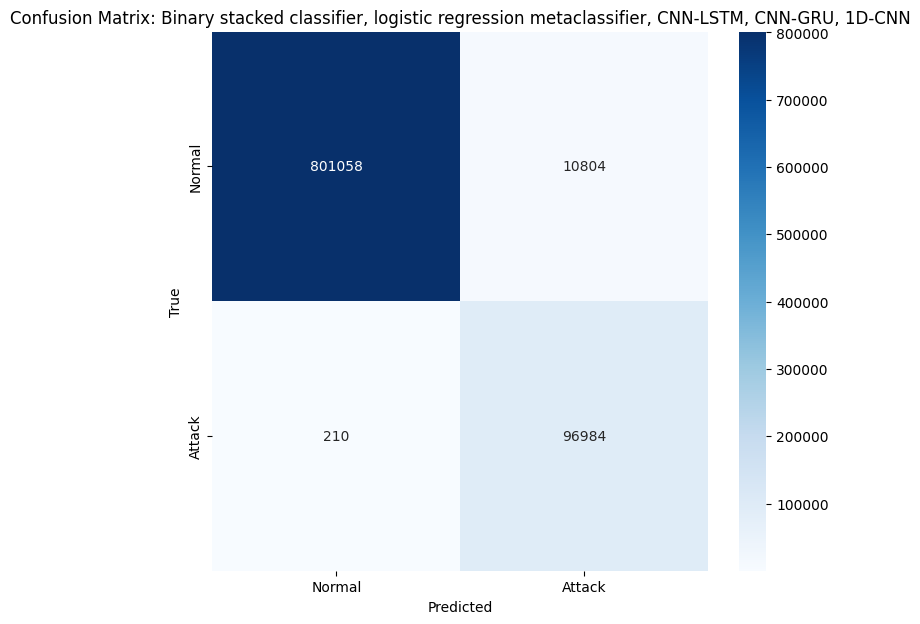

In [29]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_log_regressor1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_stacked_log_regressor1_metics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, logistic regression metaclassifier, CNN-LSTM, CNN-GRU, 1D-CNN')

In [30]:
output_layer = bin_stacked_log_regressor1.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[0.66042936]
 [2.0939634 ]
 [2.4341958 ]]
Logistic regressor bias:  [-2.4953535]


In [31]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
]

bin_kappa_weights = [
    bin_cnn_lstm_metrics[4],
    bin_cnn_gru_metrics[4],
    bin_cnn1d_metrics[4],
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]


sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)

bin_kappa_weighted_regressor1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_kappa_weighted_regressor1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_regressor1.summary()

tf.Tensor([0.33221456 0.33519524 0.33259016], shape=(3,), dtype=float32)


Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │      4,841 │ input_layer_5[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      7,977 │ input_layer_5[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, None, 1)   │      1,917 │ input_layer_5[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[5][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[5… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, None, 1)   │          4 │ lambda_4[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,739 (57.57 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 14,735 (57.56 KB)

Epoch 1/3
  17683/Unknown 193s 11ms/step - accuracy: 0.9603 - loss: 0.5545 - precision: 0.9747 - recall: 0.9361

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17685/17685 ━━━━━━━━━━━━━━━━━━━━ 242s 13ms/step - accuracy: 0.9603 - loss: 0.5545 - precision: 0.9747 - recall: 0.9361 - val_accuracy: 0.9979 - val_loss: 0.5024 - val_precision: 0.9970 - val_recall: 0.9988
Epoch 2/3
17685/17685 ━━━━━━━━━━━━━━━━━━━━ 241s 14ms/step - accuracy: 0.9975 - loss: 0.5058 - precision: 0.9964 - recall: 0.9985 - val_accuracy: 0.9979 - val_loss: 0.5024 - val_precision: 0.9970 - val_recall: 0.9988
Epoch 3/3
17685/17685 ━━━━━━━━━━━━━━━━━━━━ 246s 14ms/step - accuracy: 0.9974 - loss: 0.5058 - precision: 0.9962 - recall: 0.9986 - val_accuracy: 0.9979 - val_loss: 0.5024 - val_precision: 0.9970 - val_recall: 0.9988


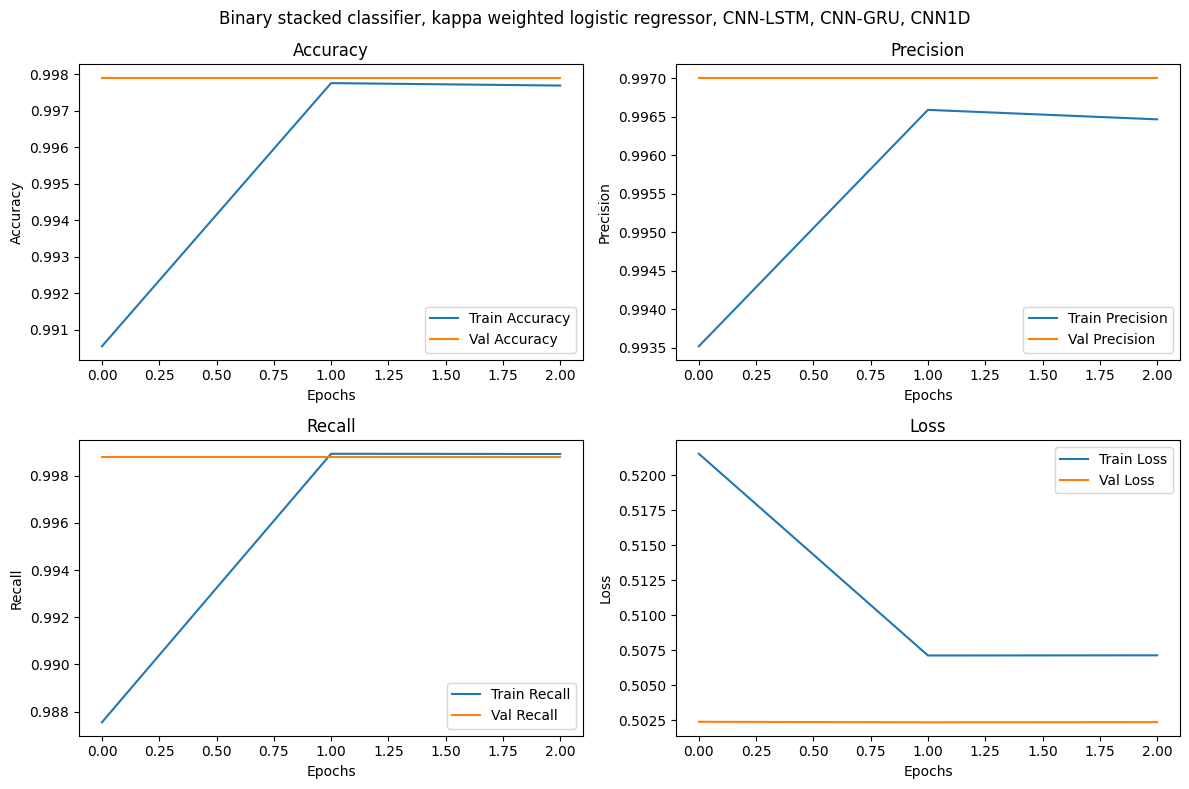

In [32]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_kappa_weighted_regressor1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Binary stacked classifier, kappa weighted logistic regressor, CNN-LSTM, CNN-GRU, CNN1D')

222/222 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step
Accuracy: 98.788%
Precision: 89.977%
Recall: 99.784%
F1 : 0.9463
Kappa: 0.9395


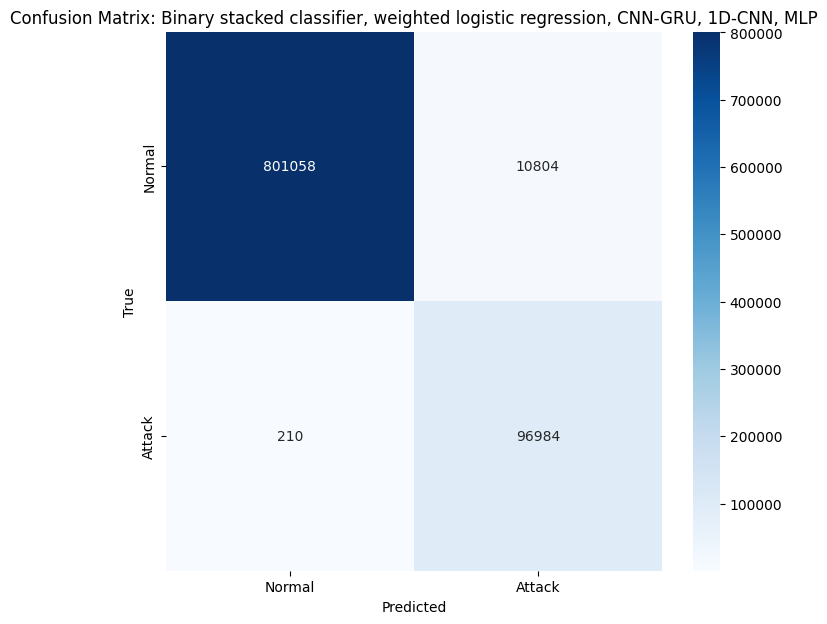

In [33]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_regressor1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_kappa_weighted_regressor1_metics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, weighted logistic regression, CNN-GRU, 1D-CNN, MLP')

In [34]:
output_layer = bin_kappa_weighted_regressor1.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[0.70650774]
 [2.2605336 ]
 [2.5730298 ]]
Logistic regressor bias:  [-0.88973325]


In [ ]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)

bin_base_classifiers = [
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
    td_bin_dnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(combined_output)
y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(y)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)


bin_stacked_dnn_classifier1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_stacked_dnn_classifier1.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_dnn_classifier1.summary()

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      7,977 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, None, 1)   │      1,917 │ input_layer_6[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, None, 1)   │      2,017 │ input_layer_6[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, None, 3)   │          0 │ binary_CNN_GRU[6… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, None, 4)   │         16 │ concatenate_5[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, None, 1)   │          5 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,952 (46.69 KB)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 11,911 (46.53 KB)

Epoch 1/3
  17682/Unknown 233s 13ms/step - accuracy: 0.9828 - loss: 0.1882 - precision: 0.9824 - recall: 0.9808

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17685/17685 ━━━━━━━━━━━━━━━━━━━━ 288s 16ms/step - accuracy: 0.9828 - loss: 0.1882 - precision: 0.9824 - recall: 0.9808 - val_accuracy: 0.9979 - val_loss: 0.1254 - val_precision: 0.9970 - val_recall: 0.9987
Epoch 2/3
17685/17685 ━━━━━━━━━━━━━━━━━━━━ 298s 17ms/step - accuracy: 0.9978 - loss: 0.1149 - precision: 0.9966 - recall: 0.9990 - val_accuracy: 0.9978 - val_loss: 0.1232 - val_precision: 0.9969 - val_recall: 0.9987
Epoch 3/3
17685/17685 ━━━━━━━━━━━━━━━━━━━━ 327s 18ms/step - accuracy: 0.9977 - loss: 0.1151 - precision: 0.9964 - recall: 0.9990 - val_accuracy: 0.9978 - val_loss: 0.1221 - val_precision: 0.9969 - val_recall: 0.9987


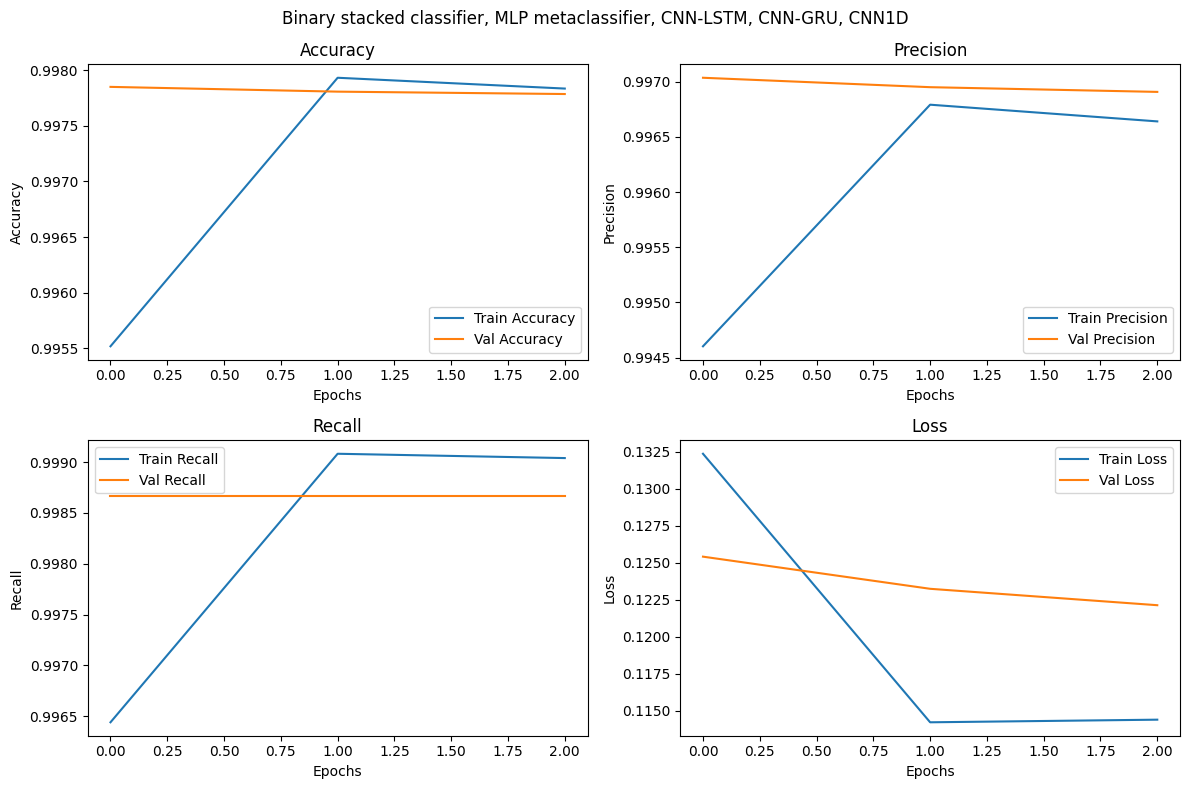

In [36]:
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = bin_stacked_dnn_classifier1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Binary stacked classifier, MLP metaclassifier, CNN-LSTM, CNN-GRU, CNN1D')

222/222 ━━━━━━━━━━━━━━━━━━━━ 73s 201ms/step
Accuracy: 98.784%
Precision: 90.066%
Recall: 99.616%
F1 : 0.9460
Kappa: 0.9392


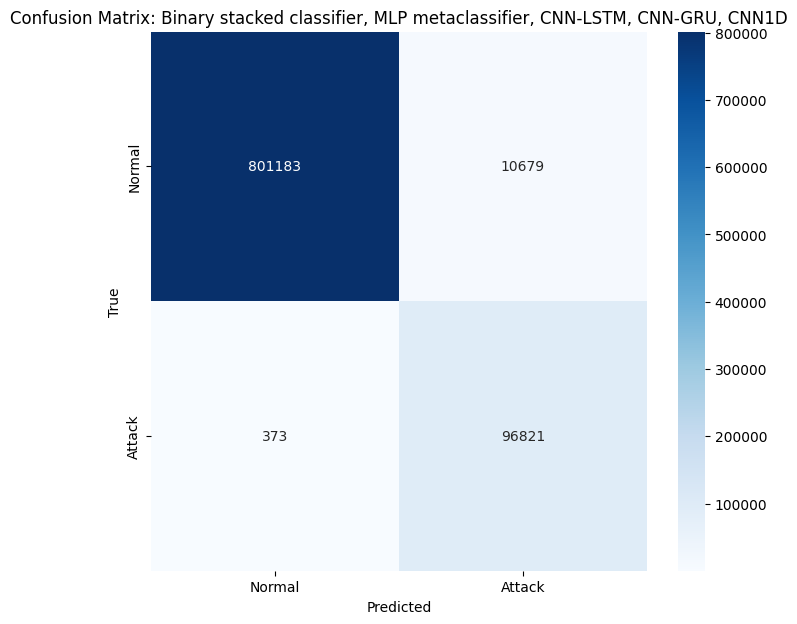

In [37]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_dnn_classifier1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_stacked_dnn_classifier_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, MLP metaclassifier, CNN-LSTM, CNN-GRU, CNN1D')

| Model                      | Accuracy | Precision | Recall  | F1       | Kappa   |
|----------------------------|----------|-----------|---------|----------|---------|
| CNN-LSTM                   | 98.792%  | 91.295%   | 98.053% | 0.9455   | 0.9388  |
| CNN-GRU                    | 98.952%  | 91.447%   | 99.505% | 0.9531   | 0.9472  |
| 1D-CNN                     | 98.795%  | 89.953%   | 99.884% | 0.9466   | 0.9398  |
| Arithmetic mean            | 98.792%  | 90.027%   | 99.755% | 0.9464   | 0.9396  |
| Improvement from best      | -0.160%  | -1.420%   |  0.250% | -0.0067  | -0.0076 |
| F1 weighted mean           | 98.793%  | 90.032%   | 99.754% | 0.9464   | 0.9397  |
| Improvement from best      | -0.159%  | -1.415%   |  0.249% | -0.0067  | -0.0075 |
| Kappa weighted mean        | 98.793%  | 90.032%   | 99.754% | 0.9464   | 0.9397  |
| Improvement from best      | -0.159%  | -1.415%   |  0.249% | -0.0067  | -0.0075 |
| Logistic regression        | 98.788%  | 89.977%   | 99.784% | 0.9463   | 0.9395  |
| Improvement from best      | -0.174%  | -1.470%   |  0.279% | -0.0068  | -0.0073 |
| Kappa weighted log. reg.   | 98.788%  | 89.977%   | 99.784% | 0.9463   | 0.9395  |
| Improvement from best      | -0.174%  | -1.470%   |  0.279% | -0.0068  | -0.0073 |
| Stacked MLP                | 98.788%  | 90.066%   | 99.616% | 0.9460   | 0.9392  |
| Improvement from best      | -0.174%  | -1.381%   |  0.111% | -0.0071  | -0.0075 |




In [46]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

bin_arithmetic_mean_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 2

bin_arithmetic_mean_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall'],
)

bin_arithmetic_mean_aggregate2.summary()

Model: "functional_92"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, None, 1)   │      1,917 │ input_layer_7[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, None, 1)   │      2,017 │ input_layer_7[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     10,081 │ input_layer_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_1 (Average) │ (None, None, 1)   │          0 │ time_distributed… │
│                     │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,015 (54.75 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,015 (54.75 KB)

222/222 ━━━━━━━━━━━━━━━━━━━━ 89s 211ms/step
Accuracy: 98.824%
Precision: 90.328%
Recall: 99.671%
F1 : 0.9477
Kappa: 0.9411


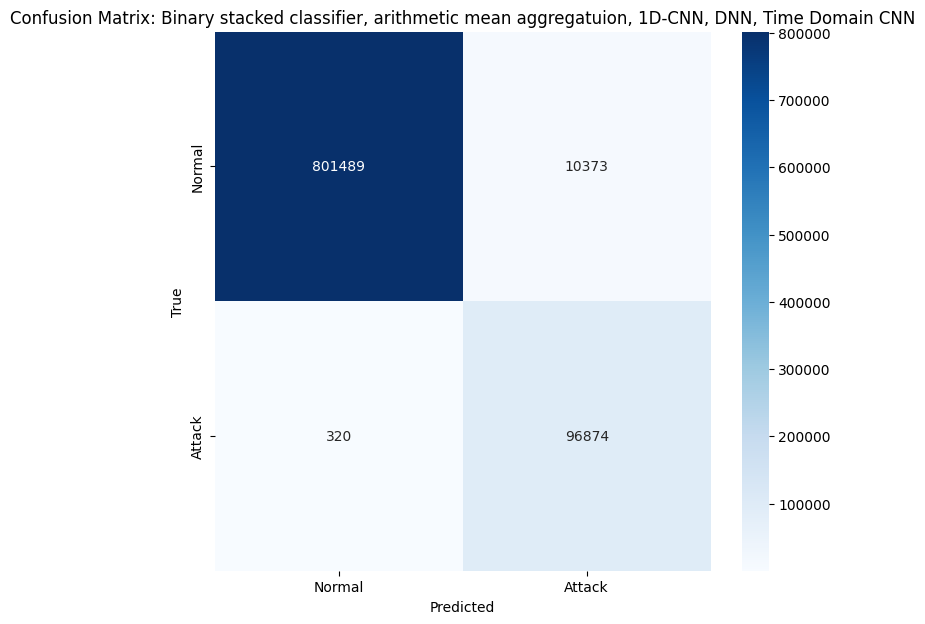

(0.9882372483103351,
 0.9032793458092068,
 0.9967076156964422,
 0.9476964014067628,
 0.9410879430694131)

In [47]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_arithmetic_mean_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, arithmetic mean aggregatuion, 1D-CNN, DNN, Time Domain CNN')

In [48]:
import math
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]


bin_f1_weights = [
    bin_cnn1d_metrics[3],
    bin_dnn_metrics[3],
    bin_td_cnn_metrics[3],
]

bin_f1_weights = [math.log(w / (1 - w)) for w in bin_f1_weights]

sum_bin_f1_weights = sum(bin_f1_weights)

bin_f1_weights = tf.constant([w / sum_bin_f1_weights for w in bin_f1_weights], dtype=tf.float32)

print(bin_f1_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_f1_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_f1_weighted_aggregate2 = tf.keras.Model(input, y)


bin_f1_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_f1_weighted_aggregate2.summary()

tf.Tensor([0.4410538  0.39079157 0.16815463], shape=(3,), dtype=float32)


Model: "functional_93"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, None, 1)   │      1,917 │ input_layer_8[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, None, 1)   │      2,017 │ input_layer_8[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     10,081 │ input_layer_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, None, 3)   │          0 │ lambda_5[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,015 (54.75 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,015 (54.75 KB)

222/222 ━━━━━━━━━━━━━━━━━━━━ 86s 199ms/step
Accuracy: 98.778%
Precision: 89.964%
Recall: 99.686%
F1 : 0.9458
Kappa: 0.9389


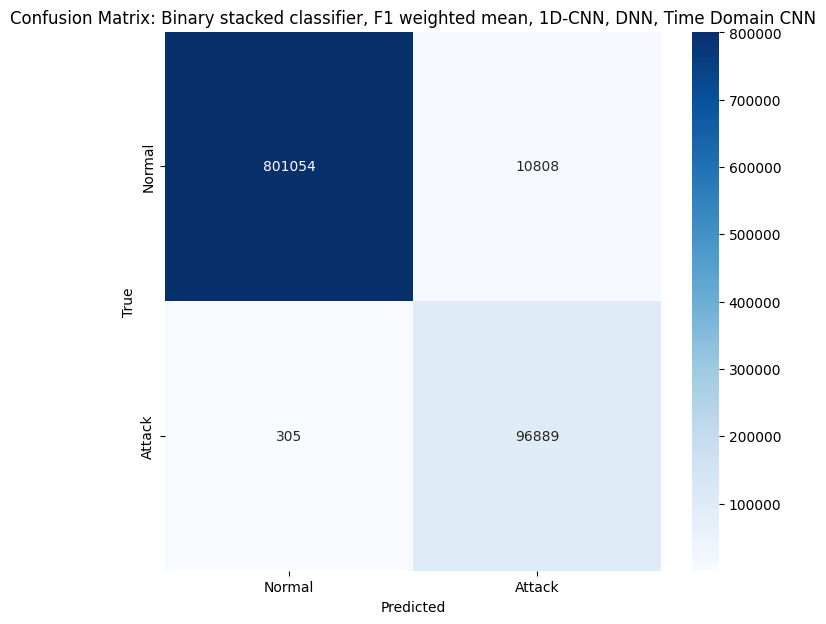

(0.9877752305688539,
 0.8996443726380493,
 0.9968619462106715,
 0.9457614048445271,
 0.9388930959556983)

In [49]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_f1_weighted_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, F1 weighted mean, 1D-CNN, DNN, Time Domain CNN')

In [50]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]


bin_kappa_weights = [
    bin_cnn1d_metrics[4],
    bin_dnn_metrics[4],
    bin_td_cnn_metrics[4],
]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_kappa_weighted_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

bin_kappa_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_aggregate2.summary()

tf.Tensor([0.41021723 0.37289178 0.21689099], shape=(3,), dtype=float32)


Model: "functional_94"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, None, 1)   │      1,917 │ input_layer_8[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, None, 1)   │      2,017 │ input_layer_8[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     10,081 │ input_layer_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[2][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, None, 3)   │          0 │ lambda_7[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,015 (54.75 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,015 (54.75 KB)

222/222 ━━━━━━━━━━━━━━━━━━━━ 93s 210ms/step
Accuracy: 98.784%
Precision: 90.014%
Recall: 99.683%
F1 : 0.9460
Kappa: 0.9392


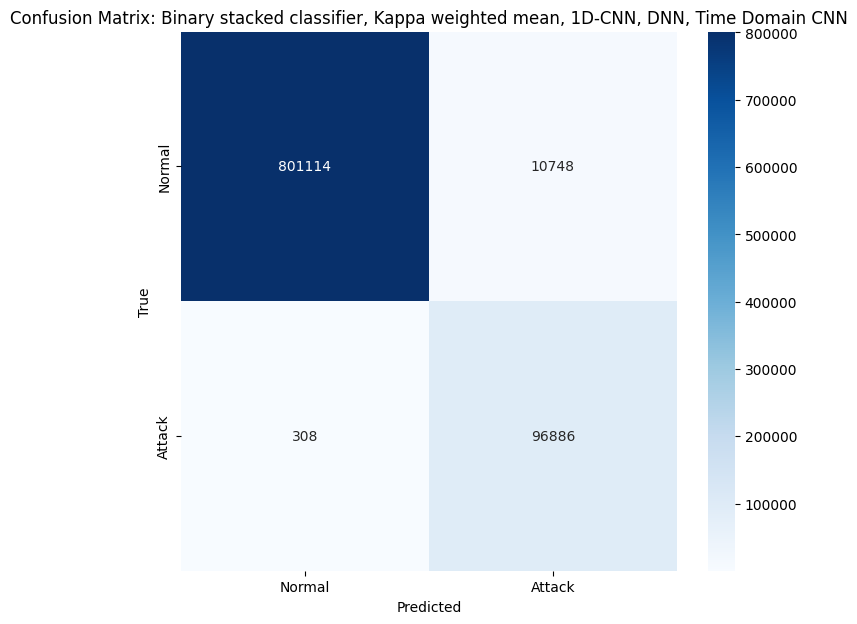

(0.9878379329766263,
 0.9001430774662281,
 0.9968310801078256,
 0.9460230046673307,
 0.939189960016936)

In [51]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Kappa weighted mean, 1D-CNN, DNN, Time Domain CNN')

In [55]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate
input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(combined_output)


bin_stacked_log_regressor2 = tf.keras.Model(input, y)

metaclassifier_epochs = 1

bin_stacked_log_regressor2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_log_regressor2.summary()

Model: "functional_96"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, None, 1)   │      1,917 │ input_layer_10[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, None, 1)   │      2,017 │ input_layer_10[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     10,081 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[4][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_17 │ (None, None, 1)   │          4 │ concatenate_10[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,019 (54.76 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 14,015 (54.75 KB)

/home/filip/.local/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


  17685/Unknown 2674s 151ms/step - accuracy: 0.9780 - loss: 0.2603 - precision: 0.9653 - recall: 0.9979

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17685/17685 ━━━━━━━━━━━━━━━━━━━━ 3076s 174ms/step - accuracy: 0.9780 - loss: 0.2603 - precision: 0.9653 - recall: 0.9979 - val_accuracy: 0.9279 - val_loss: 0.2530 - val_precision: 0.9967 - val_recall: 0.8585


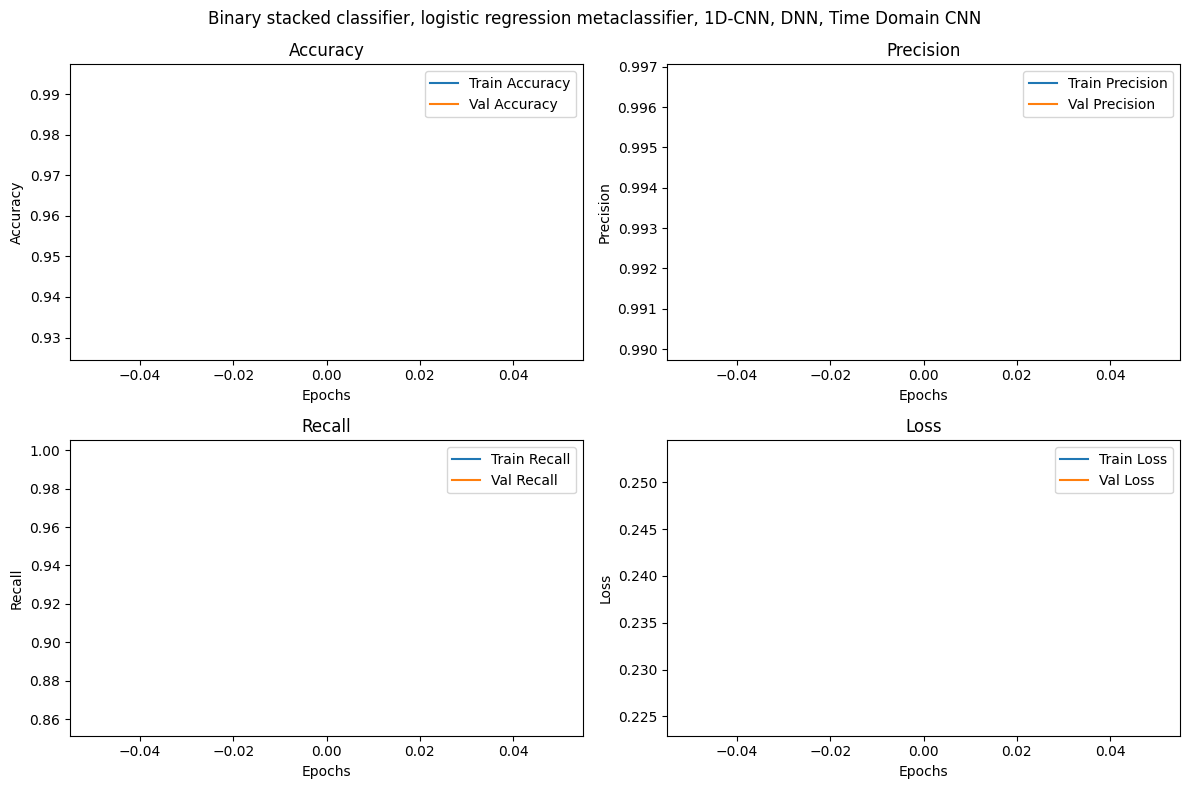

In [56]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

tf.config.run_functions_eagerly(True)
history = bin_stacked_log_regressor2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)
tf.config.run_functions_eagerly(False)
plot_model_history(history.history, 'Binary stacked classifier, logistic regression metaclassifier, 1D-CNN, DNN, Time Domain CNN')

In [57]:
output_layer = bin_stacked_log_regressor2.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[2.0049667]
 [1.8644738]
 [1.4751499]]
Logistic regressor bias:  [-2.6142528]


222/222 ━━━━━━━━━━━━━━━━━━━━ 104s 233ms/step
Accuracy: 98.791%
Precision: 90.069%
Recall: 99.683%
F1 : 0.9463
Kappa: 0.9395


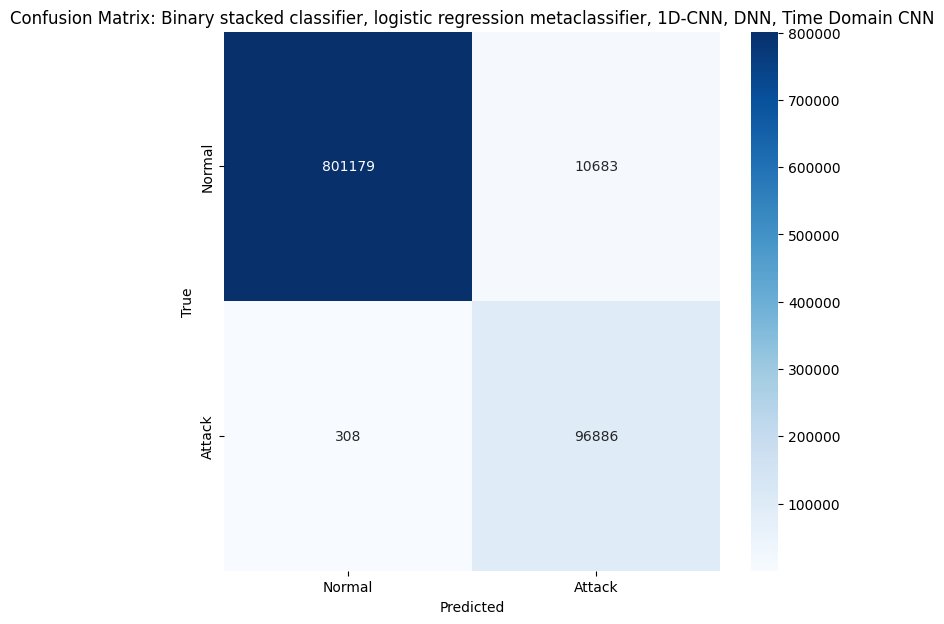

(0.9879094357223317,
 0.9006870009017468,
 0.9968310801078256,
 0.9463233103636888,
 0.9395304762396386)

In [58]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_log_regressor2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, logistic regression metaclassifier, 1D-CNN, DNN, Time Domain CNN')

In [59]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]


bin_kappa_weights = [
    bin_cnn1d_metrics[4],
    bin_dnn_metrics[4],
    bin_td_cnn_metrics[4],
]


sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)

bin_kappa_weighted_regressor2 = tf.keras.Model(input, y)

metaclassifier_epochs = 1

bin_kappa_weighted_regressor2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_regressor2.summary()

tf.Tensor([0.3638213  0.35551625 0.28066245], shape=(3,), dtype=float32)


Model: "functional_97"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, None, 1)   │      1,917 │ input_layer_11[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, None, 1)   │      2,017 │ input_layer_11[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     10,081 │ input_layer_11[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[5][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_20 │ (None, None, 1)   │          4 │ lambda_9[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,019 (54.76 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 14,015 (54.75 KB)

  17685/Unknown 2596s 147ms/step - accuracy: 0.9664 - loss: 0.5260 - precision: 0.9670 - recall: 0.9627

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17685/17685 ━━━━━━━━━━━━━━━━━━━━ 3021s 171ms/step - accuracy: 0.9664 - loss: 0.5260 - precision: 0.9670 - recall: 0.9627 - val_accuracy: 0.9288 - val_loss: 0.4888 - val_precision: 0.9964 - val_recall: 0.8607


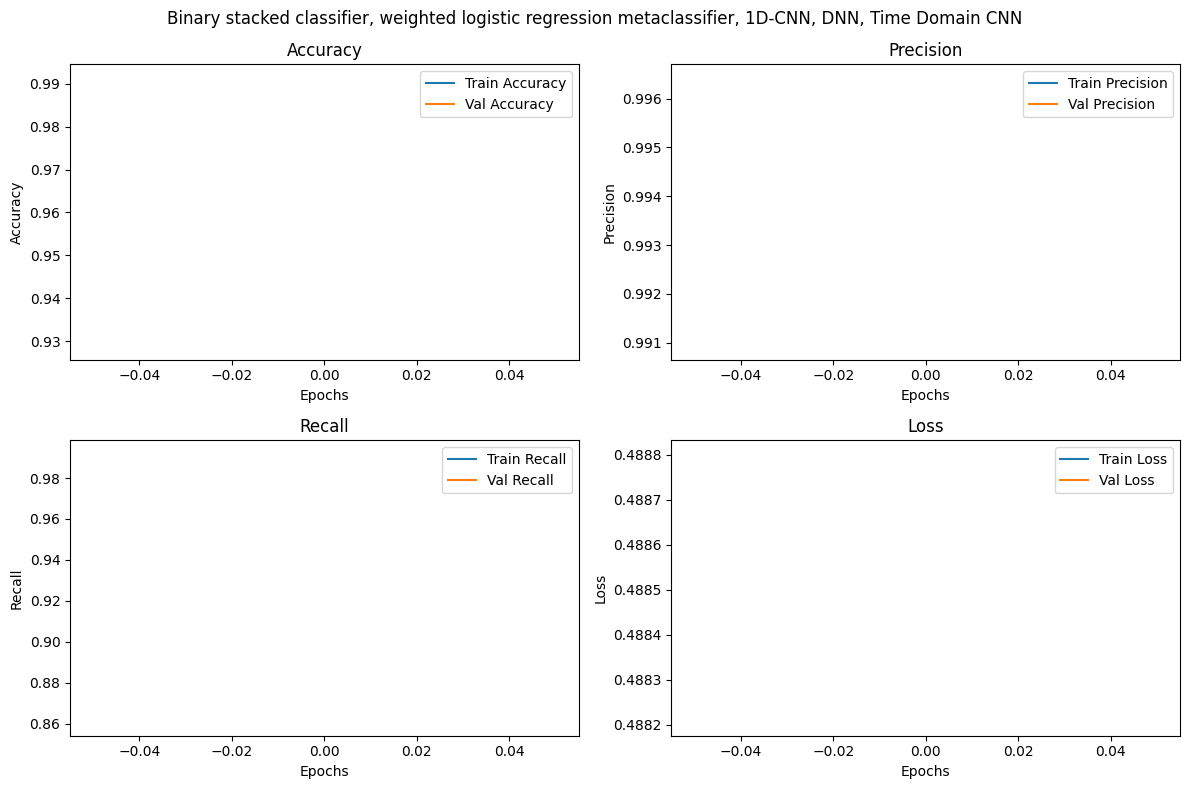

In [60]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

tf.config.run_functions_eagerly(True)
history = bin_kappa_weighted_regressor2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)
tf.config.run_functions_eagerly(False)

plot_model_history(history.history, 'Binary stacked classifier, weighted logistic regression metaclassifier, 1D-CNN, DNN, Time Domain CNN')

In [61]:
output_layer = bin_kappa_weighted_regressor2.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[2.4550674]
 [2.2643774]
 [1.4624257]]
Logistic regressor bias:  [-1.0405378]


222/222 ━━━━━━━━━━━━━━━━━━━━ 91s 213ms/step
Accuracy: 98.779%
Precision: 89.972%
Recall: 99.686%
F1 : 0.9458
Kappa: 0.9389


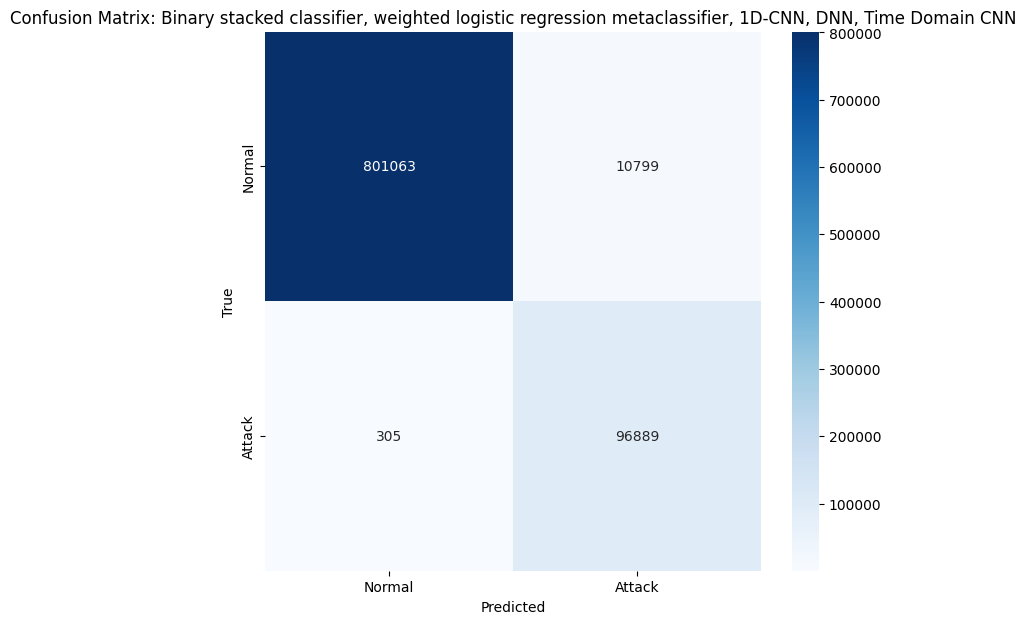

(0.9877851309490284,
 0.8997195602109799,
 0.9968619462106715,
 0.9458029499907263,
 0.9389402085504365)

In [62]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_regressor2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, weighted logistic regression metaclassifier, 1D-CNN, DNN, Time Domain CNN')

In [63]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(combined_output)
y = TimeDistributed(Dense(4, activation='relu', kernel_regularizer='l2'))(y)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer='l2'))(y)


bin_stacked_dnn_classifier2 = tf.keras.Model(input, y)

metaclassifier_epochs = 1

bin_stacked_dnn_classifier2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_dnn_classifier2.summary()

Model: "functional_98"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, None, 1)   │      1,917 │ input_layer_11[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, None, 1)   │      2,017 │ input_layer_11[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │     10,081 │ input_layer_11[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[6][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, None, 4)   │         16 │ concatenate_12[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, None, 1)   │          5 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,056 (54.91 KB)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 14,015 (54.75 KB)

In [ ]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1).take(5000)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1).take(1000)

tf.config.run_functions_eagerly(True)
history = bin_stacked_dnn_classifier2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)
tf.config.run_functions_eagerly(False)

plot_model_history(history.history, 'Binary stacked classifier, MLP metaclassifier, 1D-CNN, DNN, Time Domain CNN')

   3482/Unknown 639s 183ms/step - accuracy: 0.8272 - loss: 0.4521 - precision: 0.7964 - recall: 0.8790

In [ ]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_dnn_classifier2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, MLP metaclassifier, 1D-CNN, DNN, Time Domain CNN')

| Model                      | Accuracy | Precision | Recall  | F1       | Kappa   |
|----------------------------|----------|-----------|---------|----------|---------|
| Time Domain CNN            | 95.407%  | 89.891%   | 64.270% | 0.7495   | 0.7250  |
| 1D-CNN                     | 98.795%  | 89.954%   | 99.884% | 0.9466   | 0.9398  |
| DNN                        | 98.788%  | 89.977%   | 99.784% | 0.9463   | 0.9395  |
| Arithmetic mean            | 98.824%  | 90.328%   | 99.671% | 0.9477   | 0.9411  |
| Improvement from best      |  0.029%  |  0.374%   | -0.213% | 0.0011   | 0.0013  |
| F1 weighted mean           | 98.788%  | 89.964%   | 99.686% | 0.9458   | 0.9389  |
| Improvement from best      |  0.000%  |  0.010%   | -0.198% | -0.0008  | -0.0007 |
| Kappa weighted mean        | 98.784%  | 90.014%   | 99.683% | 0.9460   | 0.9392  |
| Improvement from best      | -0.004%  |  0.060%   | -0.201% | -0.0006  | -0.0004 |
| Logistic regression        | 98.791%  | 90.069%   | 99.683% | 0.9463   | 0.9395  |
| Improvement from best      |  0.003%  |  0.155%   | -0.201% | -0.0003  | -0.0001 |

In [16]:
import multiclass_cnn_lstm
import data_utils

mul_cnn_lstm_model = multiclass_cnn_lstm.multiclass_CNN_LSTM_model()

if not mul_cnn_lstm_model.built:
    dataset_lambda = lambda x: data_utils.create_multiclass_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        mul_cnn_lstm_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[multiclass_cnn_lstm.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Multiclass CNN-LSTM")
    print(history)
    #loading best checkpoint
    mul_cnn_lstm_model = multiclass_cnn_lstm.multiclass_CNN_LSTM_model()
    
mul_cnn_lstm_model.name = 'mul_CNN-LSTM'    
mul_cnn_lstm_model.summary()


Model loaded from saved_models/multiclass_cnn_lstm.keras


Model: "mul_CNN-LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 32)       │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 24)       │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 16)       │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 16)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 8)        │           136 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 8)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, None, 3)        │            27 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,579 (56.95 KB)

 Trainable params: 4,859 (18.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,720 (37.97 KB)

/home/filip/.local/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 79s 358ms/step
Accuracy: 99.089%
Precision: 95.965%
Recall: 99.308%
F1 : 0.9751
Kappa: 0.9552


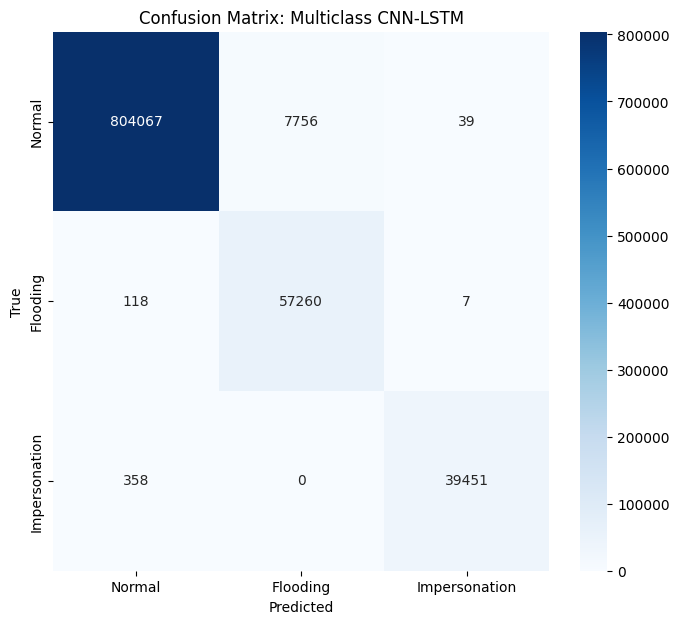

In [20]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_cnn_lstm_model.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_cnn_lstm_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass CNN-LSTM", binary=False, average='macro')


In [38]:
import multiclass_cnn_gru
import data_utils

mul_cnn_gru_model = multiclass_cnn_gru.multiclass_CNN_GRU_model()

if not mul_cnn_gru_model.built:
    dataset_lambda = lambda x: data_utils.create_multiclass_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        mul_cnn_gru_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[multiclass_cnn_gru.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Multiclass CNN-GRU")
    print(history)
    #loading best checkpoint
    mul_cnn_gru_model = multiclass_cnn_gru.multiclass_CNN_GRU_lite()
    
mul_cnn_gru_model.name = 'mul_CNN-GRU'    
mul_cnn_gru_model.summary()


Model loaded from saved_models/multiclass_cnn_gru.keras


Model: "mul_CNN-GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 64)       │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 48)       │        11,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 32)       │         1,568 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 3)        │            99 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,347 (212.30 KB)

 Trainable params: 18,115 (70.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36,232 (141.54 KB)

222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Accuracy: 98.938%
Precision: 95.231%
Recall: 99.318%
F1 : 0.9711
Kappa: 0.9481


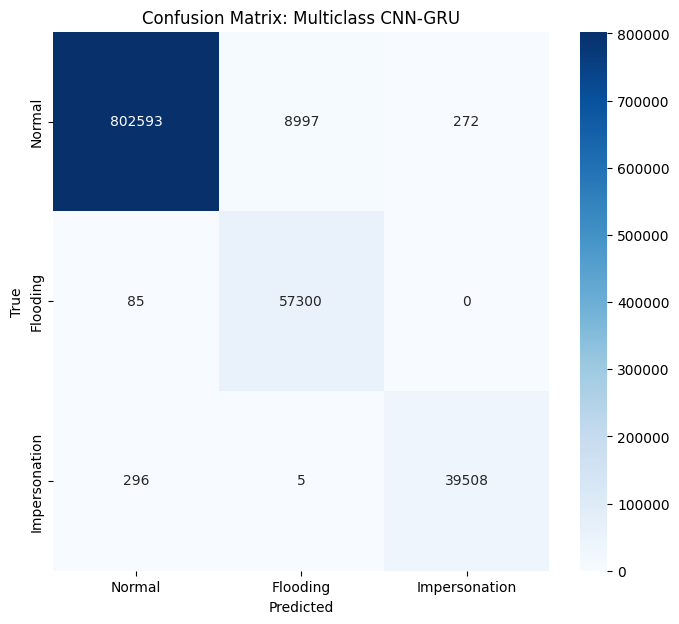

In [39]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_cnn_gru_model.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_cnn_gru_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass CNN-GRU", binary=False, average='macro')


In [40]:
import multiclass_td_cnn
import data_utils

mul_td_cnn_model = multiclass_td_cnn.multiclass_time_domain_CNN_model()

if not mul_td_cnn_model.built:
    dataset_lambda = lambda x: data_utils.create_multiclass_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        mul_td_cnn_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[multiclass_td_cnn.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Multiclass Time-Domain CNN")
    print(history)
    #loading best checkpoint
    mul_td_cnn_model = multiclass_td_cnn.multiclass_time_domain_CNN_model()
    
    
mul_td_cnn_model.summary()


Model loaded from saved_models/multiclass_td_cnn.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (32, 128, 32)          │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 128, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (32, 128, 16)          │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 128, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 128, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (32, 128, 3)           │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,155 (117.80 KB)

 Trainable params: 10,019 (39.14 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 20,040 (78.29 KB)

I0000 00:00:1733762807.196965  176685 service.cc:148] XLA service 0x5646b370d5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733762807.197009  176685 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1


 40/222 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

I0000 00:00:1733762815.476359  176685 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step
Accuracy: 95.941%
Precision: 96.632%
Recall: 71.511%
F1 : 0.7397
Kappa: 0.7575


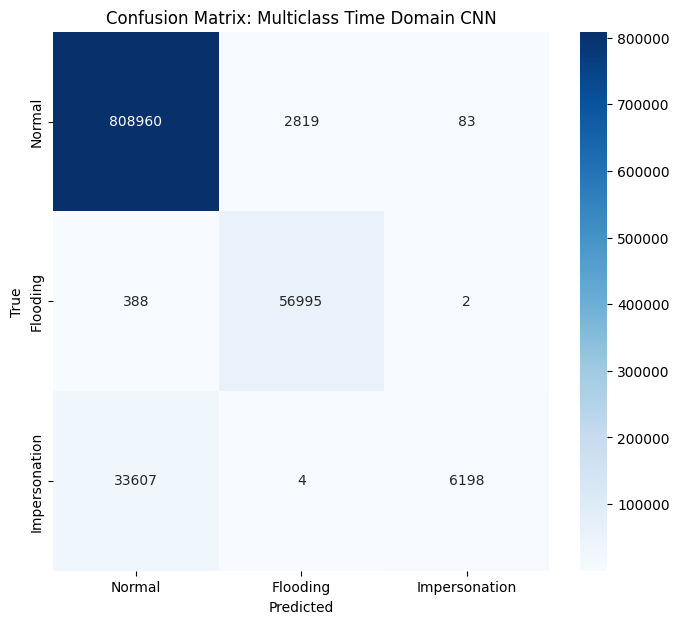

In [41]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_td_cnn_model.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_td_cnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass Time Domain CNN", binary=False, average='macro')


Model loaded from saved_models/multiclass_cnn1d.keras


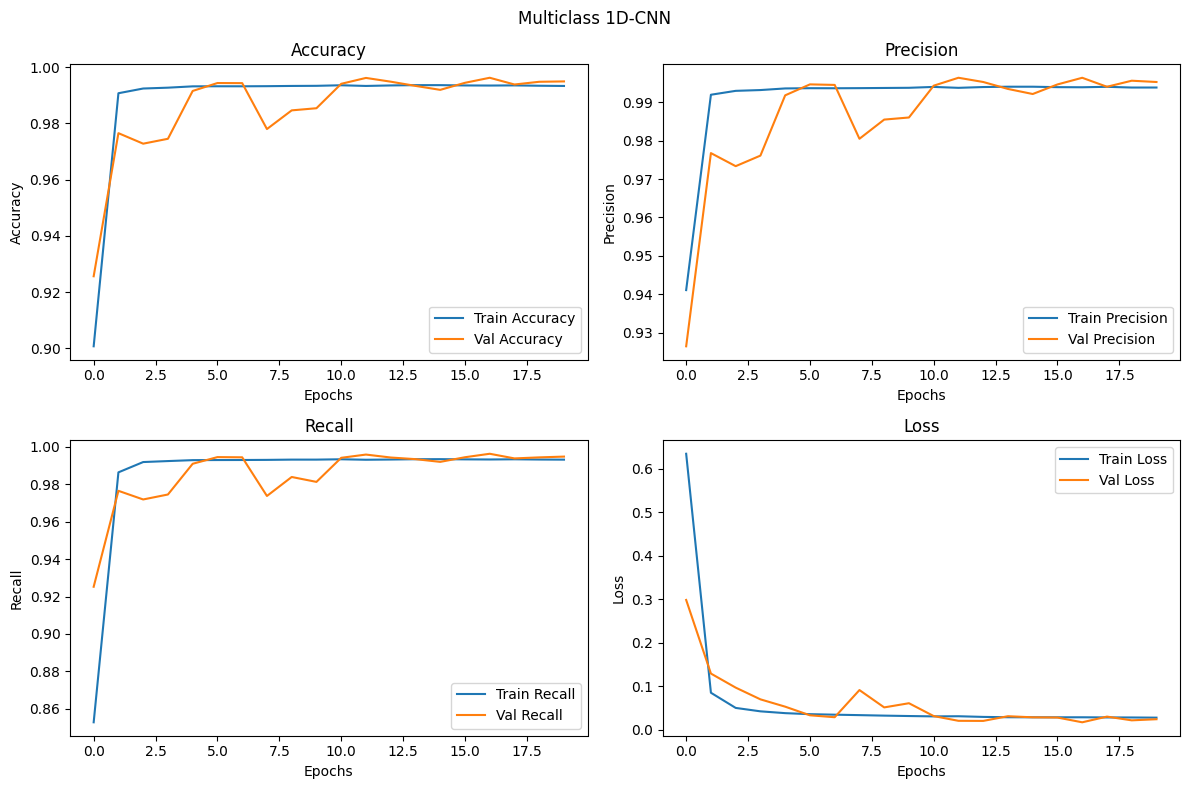

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 39)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 32)          │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 24)          │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 24)          │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 24)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 16)          │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,723 (34.08 KB)

 Trainable params: 2,859 (11.17 KB)

 Non-trainable params: 144 (576.00 B)

 Optimizer params: 5,720 (22.35 KB)

In [42]:
import multiclass_cnn1d
import data_utils

mul_cnn1d_model = multiclass_cnn1d.multiclass_CNN1D_model()

if not mul_cnn1d_model.built:
    mul_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    mul_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = mul_cnn1d_model.fit(
            mul_bal_train_ds,
            validation_data = mul_bal_val_ds,
            epochs=30,
            callbacks = [multiclass_cnn1d.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Multiclass 1D-CNN')
else:
    history = {'accuracy': [0.9007068872451782, 0.9907571077346802, 0.9924363493919373, 0.9927367568016052, 0.9932060241699219, 0.993236780166626, 0.9932265281677246, 0.9932692050933838, 0.9933528304100037, 0.9933954477310181, 0.9935917258262634, 0.9933511018753052, 0.9935320019721985, 0.9936361312866211, 0.9936361312866211, 0.9935286045074463, 0.99349445104599, 0.993545651435852, 0.9934244751930237, 0.9933443069458008], 'loss': [0.6346458792686462, 0.08526468276977539, 0.050390712916851044, 0.04251681640744209, 0.03836489096283913, 0.03599055856466293, 0.03482906520366669, 0.03380075842142105, 0.0326605960726738, 0.031728725880384445, 0.030906861647963524, 0.031238794326782227, 0.029723120853304863, 0.028944529592990875, 0.02879839576780796, 0.02880522981286049, 0.02885531075298786, 0.028528690338134766, 0.028405101969838142, 0.028012098744511604], 'precision': [0.9410816431045532, 0.9919870495796204, 0.9930007457733154, 0.9932079911231995, 0.9936286807060242, 0.9936918020248413, 0.9936766624450684, 0.9937059283256531, 0.993752658367157, 0.9937967658042908, 0.9940236806869507, 0.9937861561775208, 0.993992269039154, 0.9940781593322754, 0.9940783977508545, 0.9939639568328857, 0.993934690952301, 0.9940524697303772, 0.9938649535179138, 0.9938679933547974], 'recall': [0.8529016971588135, 0.9862226843833923, 0.9917213320732117, 0.9922417998313904, 0.9927350282669067, 0.9927879571914673, 0.9928135275840759, 0.9928766489028931, 0.993014931678772, 0.993014931678772, 0.993197500705719, 0.9929432272911072, 0.9930610060691833, 0.9932282567024231, 0.9932623505592346, 0.9931514263153076, 0.993086576461792, 0.9931889772415161, 0.9930610060691833, 0.9930012822151184], 'val_accuracy': [0.9256271719932556, 0.9765490889549255, 0.9728077054023743, 0.9745497703552246, 0.991568386554718, 0.9943878650665283, 0.9943503141403198, 0.9780124425888062, 0.9846590757369995, 0.9854202270507812, 0.9941091537475586, 0.9962049722671509, 0.9948703050613403, 0.9933694005012512, 0.9919596910476685, 0.9944682717323303, 0.9962639212608337, 0.9938679337501526, 0.9948327541351318, 0.9949613809585571], 'val_loss': [0.2985839247703552, 0.12935712933540344, 0.09706024825572968, 0.07007023692131042, 0.05325038731098175, 0.03342268988490105, 0.028993023559451103, 0.09140735864639282, 0.05155725032091141, 0.06116659566760063, 0.03162522614002228, 0.02073124423623085, 0.020512443035840988, 0.03131570294499397, 0.0287551898509264, 0.028245512396097183, 0.01732785999774933, 0.03038383275270462, 0.02181694470345974, 0.024393843486905098], 'val_precision': [0.9264398217201233, 0.9767805933952332, 0.9733746647834778, 0.9761265516281128, 0.9918332695960999, 0.9946862459182739, 0.9945470094680786, 0.9805127382278442, 0.9855123162269592, 0.986058235168457, 0.9943482279777527, 0.9964115023612976, 0.9953096508979797, 0.9934965968132019, 0.9921765923500061, 0.9946699142456055, 0.996407687664032, 0.9940638542175293, 0.9956412315368652, 0.9953066110610962], 'val_recall': [0.9251983165740967, 0.976372241973877, 0.9717624187469482, 0.974410355091095, 0.9908018708229065, 0.9943556785583496, 0.9942485094070435, 0.9736224412918091, 0.9837532043457031, 0.9811374545097351, 0.9939804673194885, 0.9957118630409241, 0.9941359162330627, 0.9932675957679749, 0.9918149709701538, 0.9942860007286072, 0.9961406588554382, 0.9936589002609253, 0.994210958480835, 0.9946237206459045]}
    plot_model_history(history, 'Multiclass 1D-CNN')

mul_cnn1d_model.summary()



28408/28408 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step
Accuracy: 98.709%
Precision: 93.883%
Recall: 99.354%
F1 : 0.9639
Kappa: 0.9376


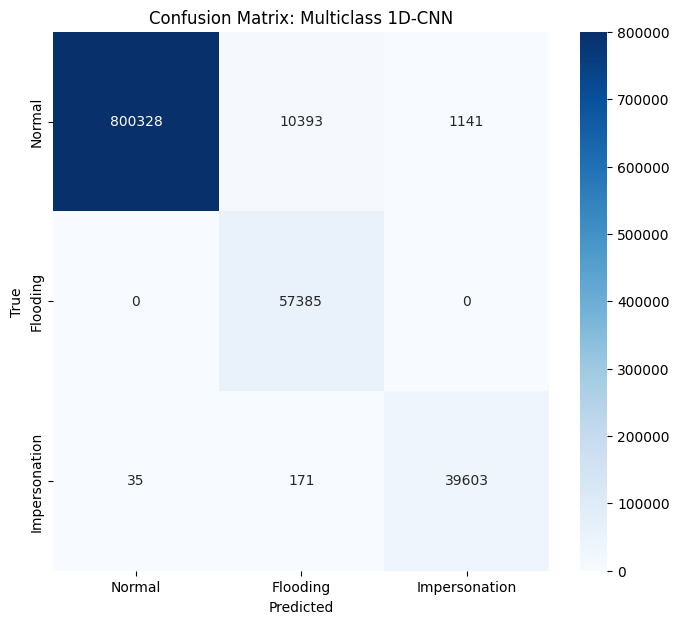

In [43]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_cnn1d_model.predict(features)
y_pred = tf.argmax(y_pred, axis=1).numpy().flatten()
y_true = tf.argmax(labels, axis=1).numpy().flatten()
    
mul_cnn1d_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass 1D-CNN", binary=False, average='macro')


Model loaded from saved_models/multiclass_dnn.keras


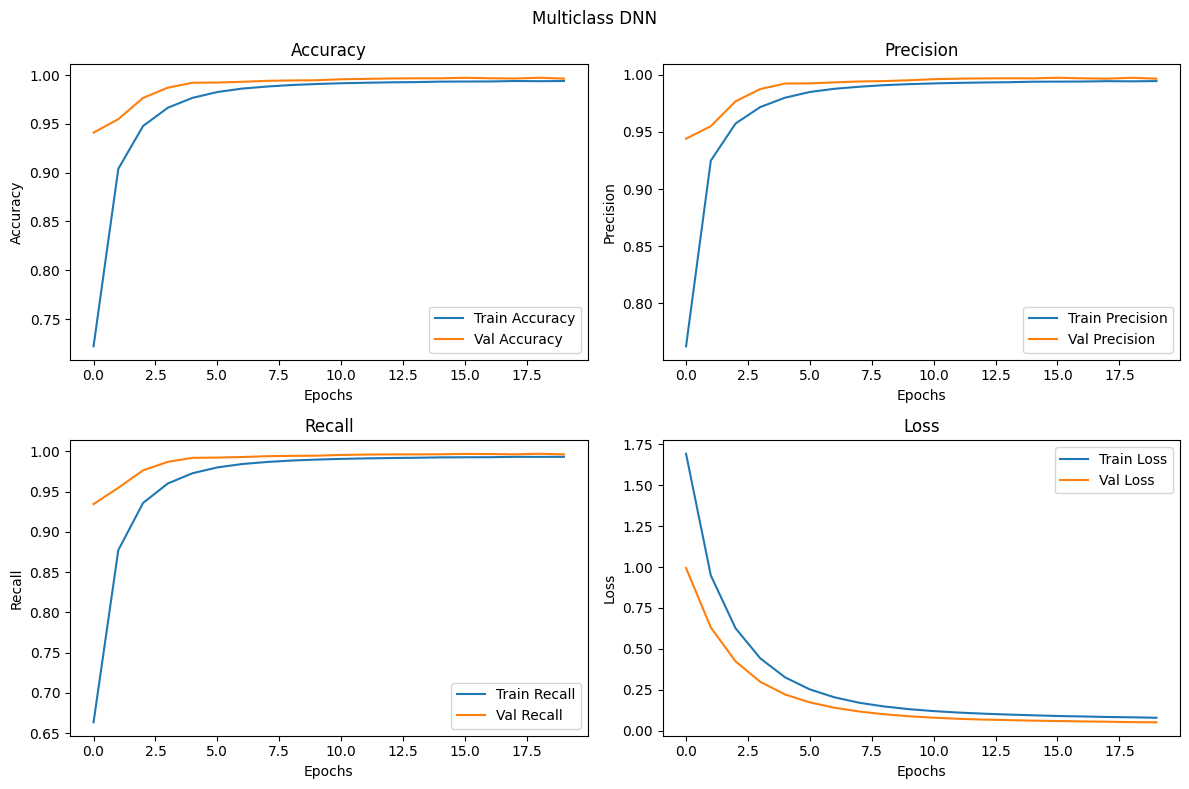

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,963 (23.30 KB)

 Trainable params: 1,955 (7.64 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 3,912 (15.29 KB)

In [44]:
import multiclass_dnn
import data_utils

mul_dnn_model = multiclass_dnn.multiclass_DNN_model()

if not mul_dnn_model.built:
    mul_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    mul_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = mul_dnn_model.fit(
            mul_bal_train_ds,
            validation_data = mul_bal_val_ds,
            epochs=30,
            callbacks = [multiclass_dnn.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Multiclass DNN')
else:
    history = {'accuracy': [0.7220519185066223, 0.9039101600646973, 0.947839617729187, 0.9665456414222717, 0.9766930341720581, 0.9826541543006897, 0.9861680269241333, 0.9882705807685852, 0.9898287057876587, 0.9908697009086609, 0.9916496276855469, 0.9921547770500183, 0.992583155632019, 0.9928220510482788, 0.9933016300201416, 0.9934176802635193, 0.9934910535812378, 0.9939296245574951, 0.9937521815299988, 0.9939313530921936], 'loss': [1.6919828653335571, 0.9487369656562805, 0.6259369254112244, 0.44205474853515625, 0.32610949873924255, 0.2525869607925415, 0.20395369827747345, 0.1709052473306656, 0.14834415912628174, 0.13202162086963654, 0.12000031769275665, 0.11117128282785416, 0.10444305092096329, 0.09908243268728256, 0.09451992064714432, 0.0900607705116272, 0.08751488476991653, 0.08414887636899948, 0.08214396983385086, 0.0794513002038002], 'precision': [0.7624614834785461, 0.9249007105827332, 0.9574190378189087, 0.9718499779701233, 0.9799951314926147, 0.9850008487701416, 0.9878191947937012, 0.9895879030227661, 0.9909629225730896, 0.9918545484542847, 0.9924875497817993, 0.992963969707489, 0.9933183789253235, 0.9935497045516968, 0.9939773678779602, 0.9940665364265442, 0.9941434860229492, 0.9944621324539185, 0.9943258166313171, 0.9945473670959473], 'recall': [0.66331946849823, 0.8772667646408081, 0.9358986020088196, 0.9601339101791382, 0.9728822112083435, 0.9800772070884705, 0.9842925071716309, 0.9868165254592896, 0.9886443018913269, 0.9897928237915039, 0.9906802773475647, 0.9913151264190674, 0.9917554259300232, 0.9920694231987, 0.9925575256347656, 0.9927026033401489, 0.9927862286567688, 0.9932470321655273, 0.9931702017784119, 0.9932947754859924], 'val_accuracy': [0.9410645365715027, 0.9548456072807312, 0.9766241312026978, 0.9871301651000977, 0.992163360118866, 0.9923617243766785, 0.9931336045265198, 0.9941251873970032, 0.994505763053894, 0.9947148561477661, 0.9957225322723389, 0.9961245656013489, 0.9965319633483887, 0.9967195391654968, 0.9967249035835266, 0.997223436832428, 0.9967731833457947, 0.9965105056762695, 0.9972716569900513, 0.9963711500167847], 'val_loss': [0.9941380023956299, 0.6306169033050537, 0.4239323139190674, 0.298564076423645, 0.22166921198368073, 0.17330124974250793, 0.1404879093170166, 0.11749791353940964, 0.10074111074209213, 0.08856925368309021, 0.07992453873157501, 0.07300786674022675, 0.06837501376867294, 0.06514357775449753, 0.061845388263463974, 0.05951591581106186, 0.05727886036038399, 0.05519590154290199, 0.052739933133125305, 0.05168865993618965], 'val_precision': [0.9441640377044678, 0.95506751537323, 0.9768344759941101, 0.9876103401184082, 0.992379903793335, 0.9925422072410583, 0.9934255480766296, 0.9942046403884888, 0.9945693612098694, 0.9952320456504822, 0.9962186217308044, 0.9966531991958618, 0.9968836903572083, 0.9970014691352844, 0.9969322681427002, 0.9974470138549805, 0.9969545602798462, 0.9966383576393127, 0.9974368214607239, 0.9966434240341187], 'val_recall': [0.9344875812530518, 0.954770565032959, 0.9764365553855896, 0.9870068430900574, 0.9919596910476685, 0.9923134446144104, 0.9929995536804199, 0.9940341114997864, 0.9944307208061218, 0.9946558475494385, 0.9955724477767944, 0.9960441589355469, 0.9962317943572998, 0.9962853789329529, 0.9963818788528442, 0.9968588948249817, 0.9966766834259033, 0.9964032769203186, 0.9970518946647644, 0.9963282346725464]}
    plot_model_history(history, 'Multiclass DNN')

mul_dnn_model.summary()



28408/28408 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step
Accuracy: 98.785%
Precision: 94.587%
Recall: 99.424%
F1 : 0.9678
Kappa: 0.9411


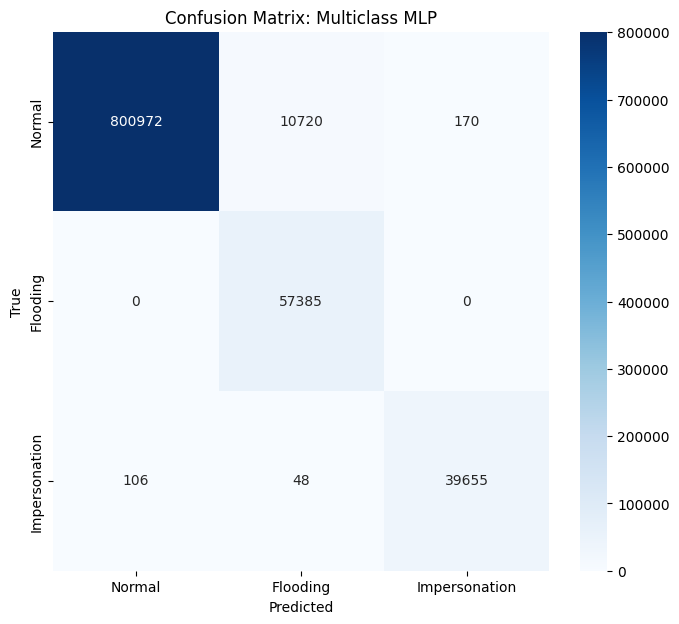

In [45]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_dnn_model.predict(features)
y_pred = tf.argmax(y_pred, axis=1).numpy().flatten()
y_true = tf.argmax(labels, axis=1).numpy().flatten()
    
mul_dnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass MLP", binary=False, average='macro')


### Results

* CNN-LSTM
    * Accuracy: 99.089%
    * Precision: 95.965%
    * Recall: 99.308%
    * F1 : 0.9751
    * Kappa: 0.9552
* CNN-GRU
    * Accuracy: 98.938%
    * Precision: 95.231%
    * Recall: 99.318%
    * F1 : 0.9711
    * Kappa: 0.9481
* Time Domain CNN
    * Accuracy: 95.941%
    * Precision: 96.632%
    * Recall: 71.511%
    * F1 : 0.7397
    * Kappa: 0.7575
* 1D-CNN
    * Accuracy: 98.709%
    * Precision: 93.883%
    * Recall: 99.354%
    * F1 : 0.9639
    * Kappa: 0.9376
* DNN
    * Accuracy: 98.785%
    * Precision: 94.587%
    * Recall: 99.424%
    * F1 : 0.9678
    * Kappa: 0.9411


In [ ]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]
#combined_output = Concatenate(axis=-2)(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

mul_arithmetic_mean_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

mul_arithmetic_mean_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_arithmetic_mean_aggregate1.summary()

In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_arithmetic_mean_aggregate1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
print(y_pred.shape, y_true.shape)
    
mul_arithmetic_mean_aggregate1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, arithmetic mean, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

In [ ]:
import math
from keras.layers import Input, Dense, TimeDistributed, Lambda

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

mul_f1_weights = [
    mul_cnn_lstm_metrics[3],
    mul_cnn_gru_metrics[3],
    mul_dnn_metrics[3],
]

mul_f1_weights = [math.log(w / (1 - w)) for w in mul_f1_weights]

sum_mul_f1_weights = sum(mul_f1_weights)

mul_f1_weights = tf.constant([w / sum_mul_f1_weights for w in mul_f1_weights], dtype=tf.float32, shape=(len(mul_f1_weights), 1))

print('F1 calculated_weights')
print(mul_f1_weights.numpy())

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_f1_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_f1_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

mul_f1_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_f1_weighted_aggregate1.summary()

In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_f1_weighted_aggregate1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_f1_weighted_aggregate1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, F1 weighted mean, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

In [ ]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

mul_kappa_weights = [
    mul_cnn_lstm_metrics[4],
    mul_cnn_gru_metrics[4],
    mul_dnn_metrics[4],
]

mul_kappa_weights = [math.log(w / (1 - w)) for w in mul_kappa_weights]

sum_mul_kappa_weights = sum(mul_kappa_weights)

mul_kappa_weights = tf.constant([w / sum_mul_kappa_weights for w in mul_kappa_weights], dtype=tf.float32,  shape=(len(mul_kappa_weights), 1))

print('Cohe Kappa calculated_weights')
print(mul_kappa_weights.numpy())

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_kappa_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_kappa_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

mul_kappa_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_kappa_weighted_aggregate1.summary()

In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_kappa_weighted_aggregate1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_kappa_weighted_aggregate1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, Kappa weighted mean, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

In [ ]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape, Dense
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Concatenate(base_classifiers_outputs)
y = TimeDistributed(Dense(3, activation='softmax'))(y)

mul_softmax_regression1 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

mul_softmax_regression1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_softmax_regression1.summary()

In [ ]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = mul_softmax_regression1.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Stacked regression classifier, CNN-LSTM, CNN-GRU, CNN1D')

In [ ]:
output_layer = mul_softmax_regression2.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Softmax regressor weights:\n", output_weights)
print("Softmax regressor bias: ", output_bias)

In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_softmax_regression1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_softmax_regression1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, softmax regression, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

In [ ]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape, Dense
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Cinactenate()(base_classifiers_outputs)
y = TimeDistributed(Dense(16, activation='relu'))(y)
y = TimeDistributed(Dense(8, activation='relu'))(y)
y = TimeDistributed(Dense(3, activation='softmax'))(y)

mul_dnn_classifier1 = tf.keras.Model(input, y)

metaclassifier_epochs = 1

mul_dnn_classifier1.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_dnn_classifier1.summary()

In [ ]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1)

history = mul_dnn_classifier1.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Multiclass classifier, MLP, CNN-LSTM, CNN-GRU, DNN')

In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_dnn_classifier1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_dnn_classifier1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, Kappa weighted mean, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

|                     | Accuarcy | Precision | Recall  | F1      | Kappa   |
|---------------------|----------|-----------|---------|---------|---------|
| CNN-LSTM            | 99,089%  | 95,965%   | 99,308% | 0,9751  | 0,9552  |
| CNN-GRU             | 98,938%  | 95,231%   | 99,318% | 0,9711  | 0,9481  |
| DNN                 | 98,709%  | 93,883%   | 99,354% | 0,9639  | 0,9411  |


In [ ]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Average
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]
#combined_output = Concatenate(axis=-2)(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

mul_arithmetic_mean_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

mul_arithmetic_mean_aggregate2.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_arithmetic_mean_aggregate2.summary()

In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_arithmetic_mean_aggregate2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
print(y_pred.shape, y_true.shape)
    
mul_arithmetic_mean_aggregate2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, arithmetic mean, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

In [ ]:
import math
from keras.layers import Input, Dense, TimeDistributed, Lambda

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

mul_f1_weights = [
    mul_td_cnn_metrics[3],
    mul_dnn_metrics[3],
    mul_cnn1d_metrics[3],
]

mul_f1_weights = [math.log(w / (1 - w)) for w in mul_f1_weights]

sum_mul_f1_weights = sum(mul_f1_weights)

mul_f1_weights = tf.constant([w / sum_mul_f1_weights for w in mul_f1_weights], dtype=tf.float32, shape=(len(mul_f1_weights), 1))

print('F1 calculated_weights')
print(mul_f1_weights.numpy())

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_f1_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_f1_weighted_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

mul_f1_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_f1_weighted_aggregate2.summary()

In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_f1_weighted_aggregate2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_f1_weighted_aggregate2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, F1 weighted mean, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

In [ ]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

mul_kappa_weights = [
    mul_td_cnn_metrics[4],
    mul_dnn_metrics[4],
    mul_cnn1d_metrics[4],
]

mul_kappa_weights = [math.log(w / (1 - w)) for w in mul_kappa_weights]

sum_mul_kappa_weights = sum(mul_kappa_weights)

mul_kappa_weights = tf.constant([w / sum_mul_kappa_weights for w in mul_kappa_weights], dtype=tf.float32,  shape=(len(mul_kappa_weights), 1))

print('Cohe Kappa calculated_weights')
print(mul_kappa_weights.numpy())

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_kappa_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_kappa_weighted_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 3

mul_kappa_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_kappa_weighted_aggregate2.summary()

In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_kappa_weighted_aggregate2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_kappa_weighted_aggregate2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, Kappa weighted mean, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

In [ ]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape, Dense
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Concatenate(base_classifiers_outputs)
y = TimeDistributed(Dense(3, activation='softmax'))(y)

mul_softmax_regression2 = tf.keras.Model(input, y)

metaclassifier_epochs = 1

mul_softmax_regression2.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_softmax_regression2.summary()

In [ ]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1).take(2000)
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1).take(500)

tf.config.run_functions_eagerly(True)
history = mul_softmax_regression2.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)
tf.config.run_functions_eagerly(False)

plot_model_history(history.history, 'Multiclass stacked classifier, softmax regression metaclassifier, Time Domain CNN, 1D-CNN, DNN')

In [ ]:
output_layer = mul_softmax_regression2.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Softmax regressor weights:\n", output_weights)
print("Softmax regressor bias: ", output_bias)

In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_softmax_regression2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_softmax_regression2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, softmax regression metaclassifier, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

In [ ]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape, Dense
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Cinactenate()(base_classifiers_outputs)
y = TimeDistributed(Dense(16, activation='relu'))(y)
y = TimeDistributed(Dense(8, activation='relu'))(y)
y = TimeDistributed(Dense(3, activation='softmax'))(y)

mul_dnn_classifier2 = tf.keras.Model(input, y)

metaclassifier_epochs = 1

mul_dnn_classifier2.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_dnn_classifier2.summary()

In [ ]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1).take(2000)
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_bal_files, filter_out_normal=False, seq_length=1, seq_shift=1).take(500)

tf.config.run_functions_eagerly(True)
history = mul_dnn_classifier2.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)
tf.config.run_functions_eagerly(False)

plot_model_history(history.history, 'Multiclass stacked classifier, MLP metaclassifier, Time Domain CNN, 1D-CNN, DNN')

In [ ]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_dnn_classifier2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_dnn_classifier2_metrics = score_and_confusion_matrix(y_pred, y_true, "MMulticlass stacked classifier, MLP metaclassifier, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')